In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [201]:
def prepare(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:

        print(f'k = {k}')

        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []
        for j in tqdm(range(0, n_samples)):
            if sample_size == -1:
                sample_size = df.shape[0]   
            sampled_indeces = random.sample(range(df.shape[0]), sample_size)
            sampled_points = [df.iloc[i] for i in sampled_indeces]
            sampled_labels = [model.labels_[i] for i in sampled_indeces]
            silhouettes.append(silhouette_score(sampled_points, sampled_labels))
        silhouettess.append(silhouettes)

        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1])
    axes[0].set_title('SSE')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1])
    axes[1].set_title('Separation')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores)
    axes[2].set_title('Silhouette')
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)


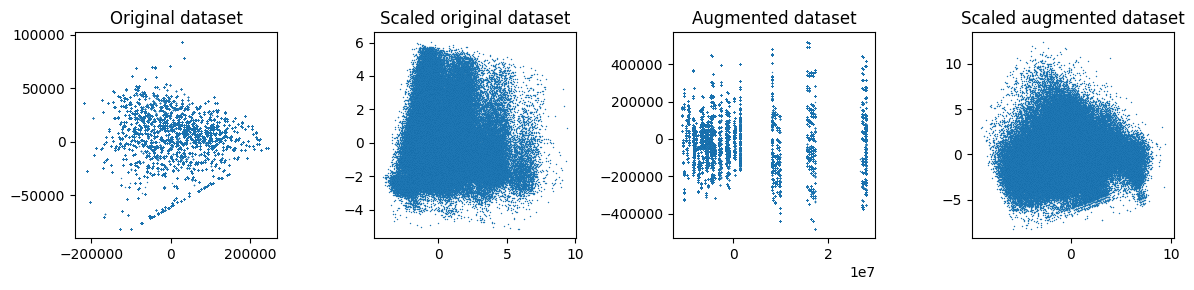

In [78]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df_init, remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df_init, remove_outliers=True, with_indicators=True)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


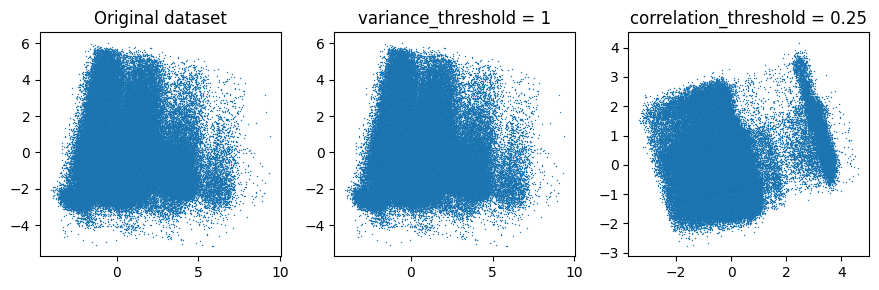

In [79]:
var_thr = 1
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_

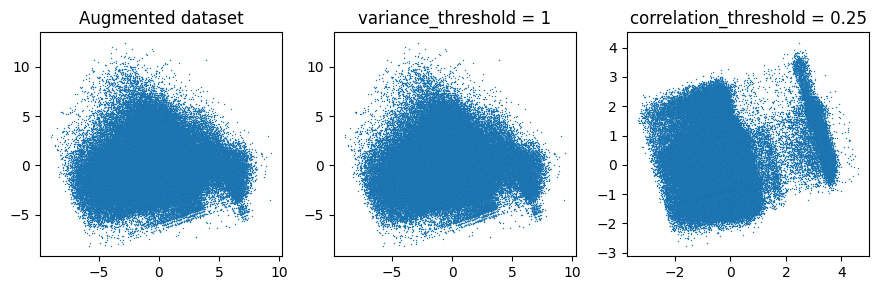

In [80]:
var_thr = 1
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### Without latitude and longitude

Dataset dimentions: (235219, 59)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 17)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 49)


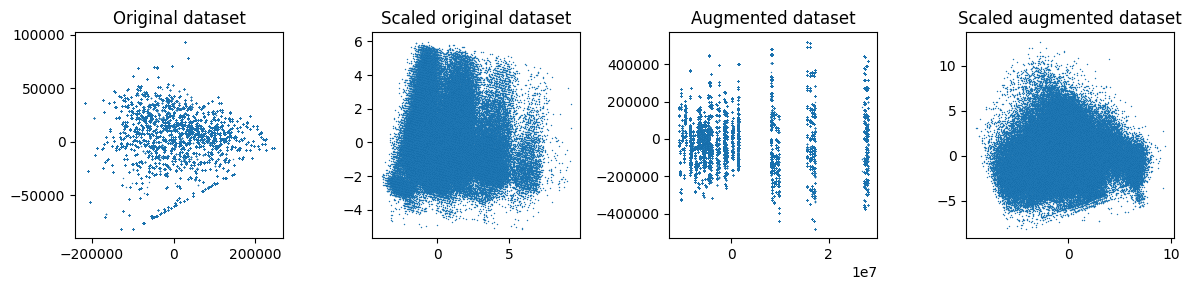

In [81]:
df_nl_init = df_init.drop(columns=['latitude', 'longitude'])
df_nl_orig, df_nl_orig_s, scaler_nl_orig = prepare(df_nl_init, remove_outliers=True, with_indicators=False)
df_nl, df_nl_s, scaler_nl = prepare(df_nl_init, remove_outliers=True, with_indicators=True)


print(f'Dataset dimentions: {df_nl_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_nl_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_nl.shape}')

pca_nl_orig = perform_PCA(df=df_nl_orig, n_components=2)
pca_nl_orig_s = perform_PCA(df=df_nl_orig_s, n_components=2)

pca_nl = perform_PCA(df=df_nl, n_components=2)
pca_nl_s = perform_PCA(df=df_nl_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_nl_orig[:, 0], pca_nl_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_nl_orig_s[:, 0], pca_nl_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca_nl[:, 0], pca_nl[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_nl_s[:, 0], pca_nl_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 17

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 16
Index(['min_age_participants', 'avg_age_participants', 'max_age_participants',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 4
Index(['min_age_participants', 'n_participants_teen', 'n_killed', 'timestamp'], dtype='object')


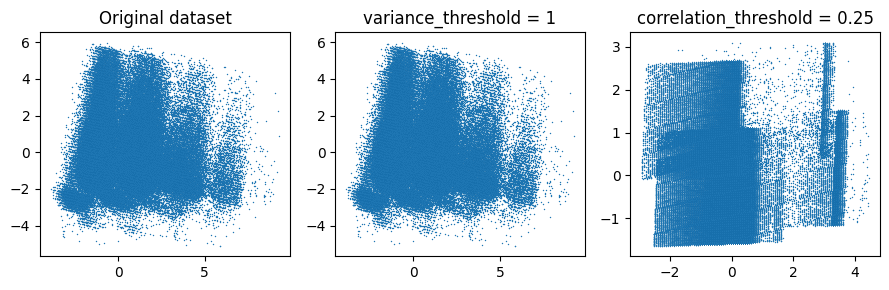

In [82]:
var_thr = 1
reduced_nl_orig_var = features_reduction_var(df_nl_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_nl_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_orig_var.columns)}')
print(reduced_nl_orig_var.columns)

corr_thr = 0.25
reduced_nl_orig = features_reduction_corr(reduced_nl_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_orig.columns)}')
print(reduced_nl_orig.columns)

pca_nl_orig_v = perform_PCA(df=reduced_nl_orig_var, n_components=2)
pca_nl_orig_c = perform_PCA(df=reduced_nl_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_nl_orig_s[:, 0], pca_nl_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_nl_orig_v[:, 0], pca_nl_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_nl_orig_c[:, 0], pca_nl_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 49

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 46
Index(['min_age_participants', 'avg_age_participants', 'max_age_participants',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes',
       'state_population', 'p_males', 'p_females', 'p_participants_teen',
       'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested',
       'p_unharmed', 'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incid

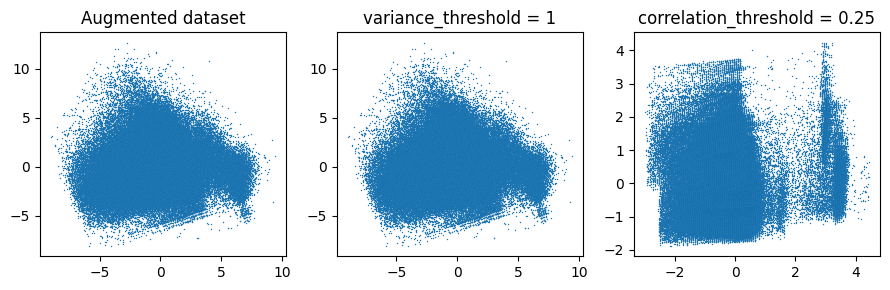

In [83]:
var_thr = 1
reduced_nl_var = features_reduction_var(df_nl_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_nl_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_var.columns)}')
print(reduced_nl_var.columns)

corr_thr = 0.25
reduced_nl = features_reduction_corr(reduced_nl_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl.columns)}')
print(reduced_nl.columns)

pca_nl_v = perform_PCA(df=reduced_nl_var, n_components=2)
pca_nl_c = perform_PCA(df=reduced_nl, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_nl_s[:, 0], pca_nl_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_nl_v[:, 0], pca_nl_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_nl_c[:, 0], pca_nl_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [190]:
k_min = 2
k_max = 10

models = k_means(df_orig_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:39<00:00,  4.44s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


k = 10


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


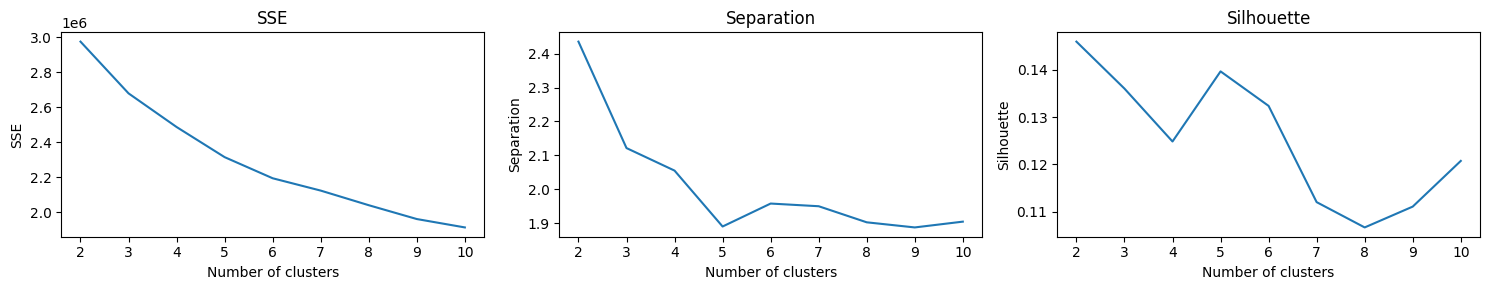

In [203]:
scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [205]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_orig_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:25<00:00, 17.02s/it]


Best mean silhouette score for k = 2:
SSE = 2974152.529572072
Separation = 2.4354565029374227
Silhouette = 0.14557715004294722


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


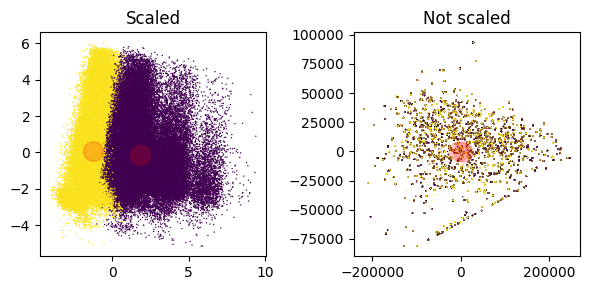

Cluster 0: 177714 points
Cluster 1: 13263 points


In [207]:
best_model_orig = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_orig_s, centroids=best_model_orig.cluster_centers_, n_components=2)

orig_points = scaler_orig.inverse_transform(df_orig_s)
orig_centroids = scaler_orig.inverse_transform(best_model_orig.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced original dataset

In [208]:
k_min = 2
k_max = 10

models = k_means(df=reduced_orig, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


k = 5


100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


k = 8


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 9


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


k = 10


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


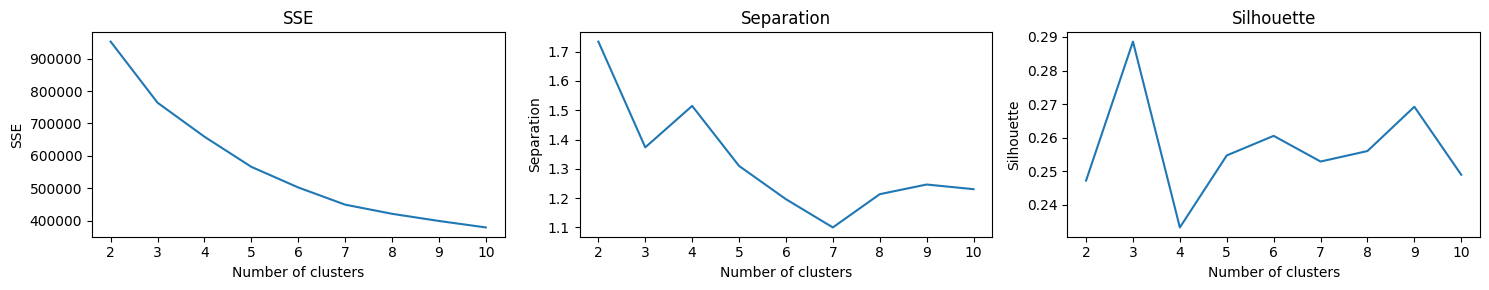

In [210]:
scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [211]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_orig, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 3


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:55<00:00, 11.12s/it]


Best mean silhouette score for k = 3:
SSE = 764004.6328146383
Separation = 1.3732157355973447
Silhouette = 0.2906734960348557


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


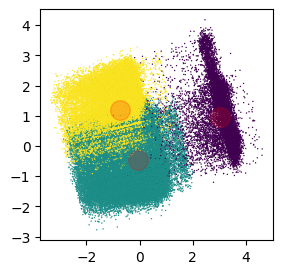

Cluster 0: 13263 points
Cluster 1: 135320 points
Cluster 2: 42394 points


In [212]:
best_model_r_orig = models[best_k]

points_pca, centroids_pca = perform_PCA(df=reduced_orig, centroids=best_model_r_orig.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_r_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model_r_orig.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [217]:
k_min = 2
k_max = 10

models = k_means(df=df_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [01:01<00:00,  6.84s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


k = 4


100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


k = 9


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


k = 10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


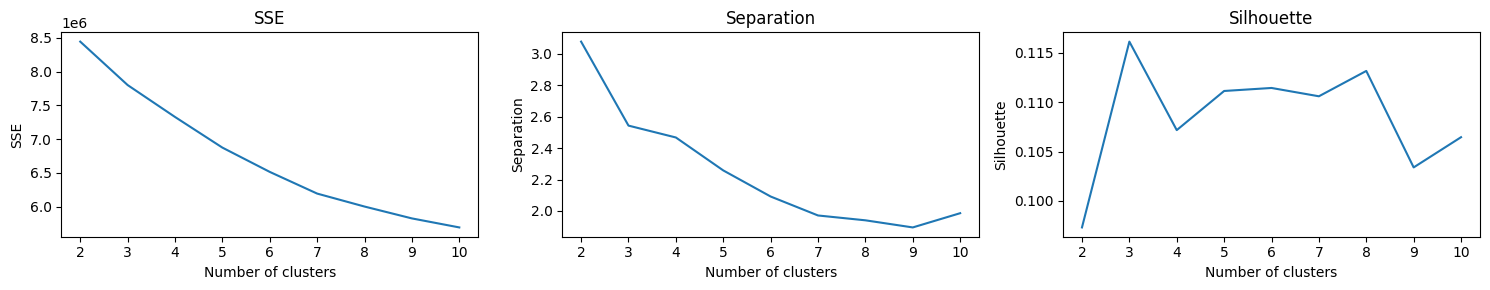

In [218]:
scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [219]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 3


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Best mean silhouette score for k = 3:
SSE = 7800450.256698627
Separation = 2.543623634825016
Silhouette = 0.11526938640247453


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


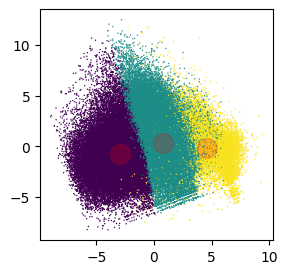

Cluster 0: 53574 points
Cluster 1: 124516 points
Cluster 2: 12887 points


In [220]:
best_model = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_s, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced augmented dataset
(the same as with the reduced original dataset)

In [224]:
k_min = 2
k_max = 10

models = k_means(df=reduced, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


k = 3


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


k = 4


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 5


100%|██████████| 3/3 [00:17<00:00,  5.85s/it]


k = 6


100%|██████████| 3/3 [00:20<00:00,  6.93s/it]


k = 7


100%|██████████| 3/3 [00:16<00:00,  5.65s/it]


k = 8


100%|██████████| 3/3 [00:17<00:00,  5.68s/it]


k = 9


100%|██████████| 3/3 [00:17<00:00,  5.75s/it]


k = 10


100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


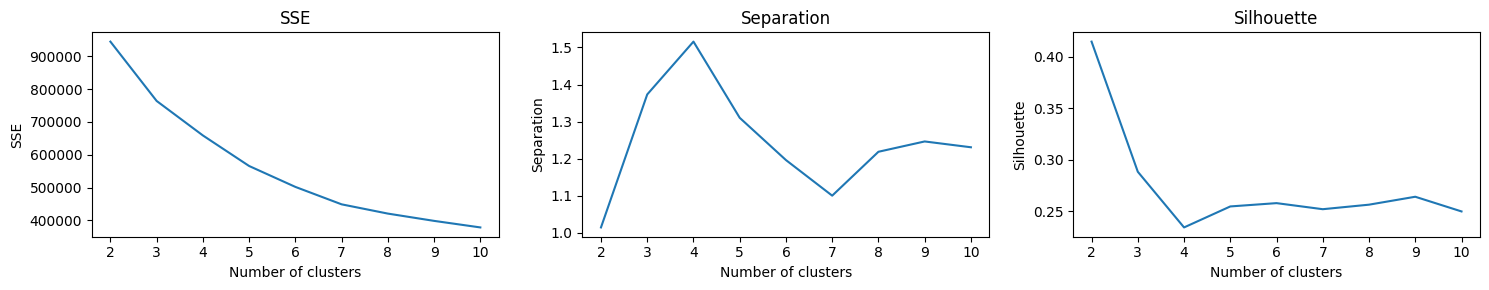

In [225]:
scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [226]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:32<00:00, 18.49s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960035
Separation = 1.014701571838864
Silhouette = 0.4123683229308628


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


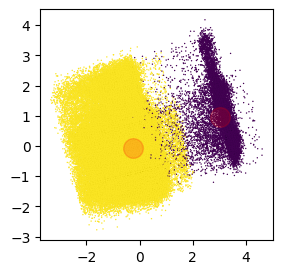

Cluster 0: 13263 points
Cluster 1: 177714 points


In [227]:
best_model_r = models[best_k]

points_pca, centroids_pca = perform_PCA(df=reduced, centroids=best_model_r.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_r.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### + Trying with only indicators

Idicator dataset dimentions: (190977, 21)


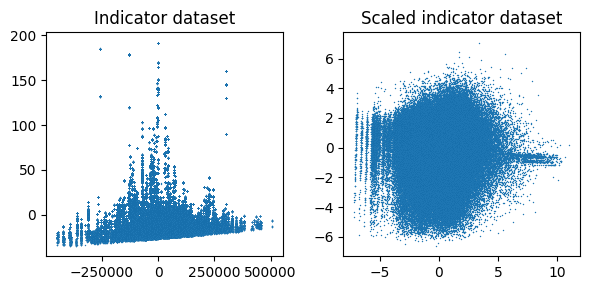

In [238]:
df_ind = df[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]

scaler_ind = StandardScaler()
df_ind_s = scaler.fit_transform(df_ind)
df_ind_s = pd.DataFrame(df_ind_s, columns=df_ind.columns)

print(f'Idicator dataset dimentions: {df_ind.shape}')

pca = perform_PCA(df=df_ind, n_components=2)
pca_s = perform_PCA(df=df_ind_s, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Indicator dataset')

plt.subplot(1, 2, 2)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled indicator dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 21

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'month_

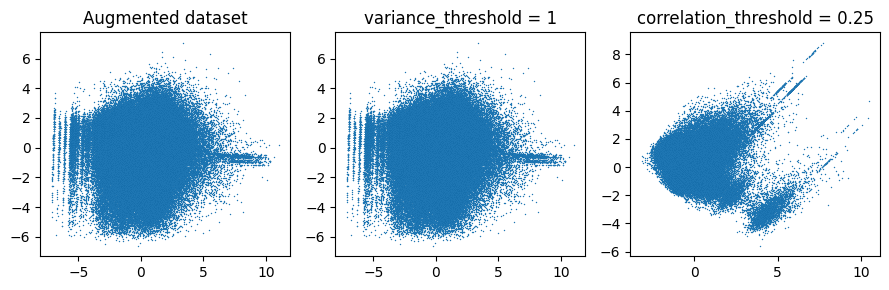

In [239]:
var_thr = 1
reduced_ind_var = features_reduction_var(df_ind_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_ind_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind_var.columns)}')
print(reduced_ind_var.columns)

corr_thr = 0.25
reduced_ind = features_reduction_corr(reduced_ind_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind.columns)}')
print(reduced_ind.columns)

pca_v = perform_PCA(df=reduced_ind_var, n_components=2)
pca_c = perform_PCA(df=reduced_ind, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### K-means on the full indicator dataset

In [240]:
k_min = 2
k_max = 10

models = k_means(df=df_ind_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:41<00:00,  4.57s/it]


k = 2


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


k = 3


100%|██████████| 3/3 [00:10<00:00,  3.35s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


k = 6


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


k = 9


100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


k = 10


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


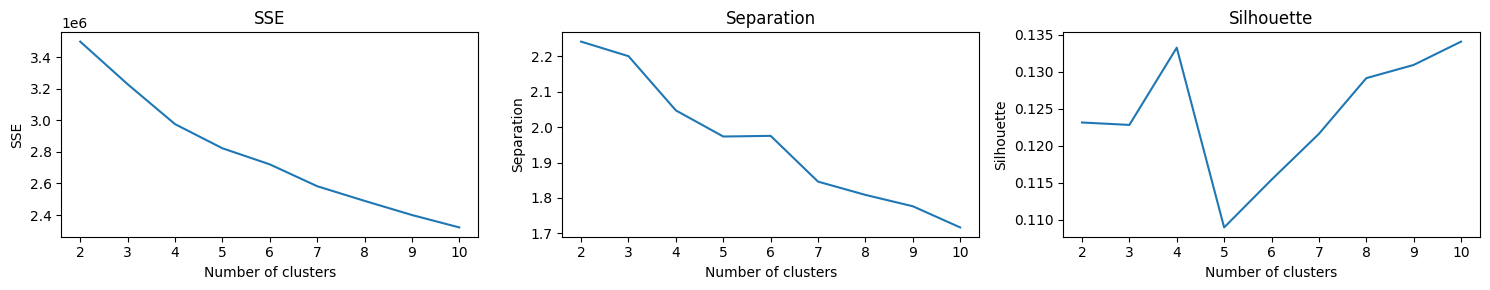

In [241]:
scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [242]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_ind_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 10


100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


Best mean silhouette score for k = 10:
SSE = 2321460.6974242013
Separation = 1.716912712990445
Silhouette = 0.13565954509073505


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


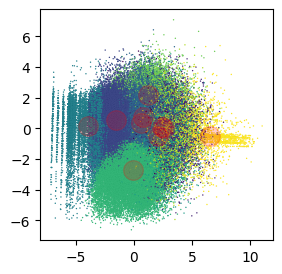

Cluster 0: 13077 points
Cluster 1: 6831 points
Cluster 2: 48811 points
Cluster 3: 56177 points
Cluster 4: 12764 points
Cluster 5: 9327 points
Cluster 6: 29630 points
Cluster 7: 4735 points
Cluster 8: 7366 points
Cluster 9: 2259 points


In [243]:
best_model_ind = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_ind_s, centroids=best_model_ind.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_ind.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model_ind.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced indicator dataset

In [250]:
k_min = 2
k_max = 10

models = k_means(df=reduced_ind, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:31<00:00,  3.46s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.06s/it]


k = 3


100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


k = 4


100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


k = 5


100%|██████████| 3/3 [00:10<00:00,  3.65s/it]


k = 6


100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


k = 7


100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


k = 8


100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


k = 9


100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


k = 10


100%|██████████| 3/3 [00:10<00:00,  3.44s/it]


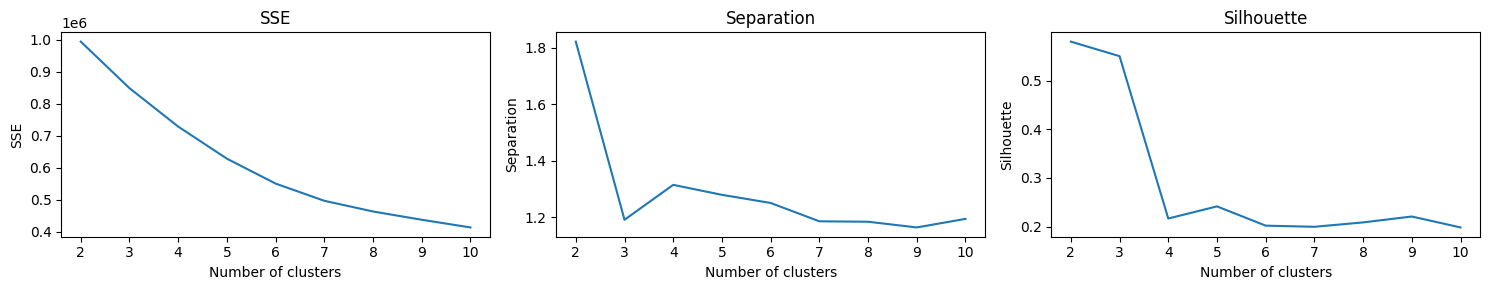

In [251]:
scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [252]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_ind, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:03<00:00, 12.80s/it]


Best mean silhouette score for k = 2:
SSE = 994469.0050359368
Separation = 1.8221097850015722
Silhouette = 0.5765703424063822


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


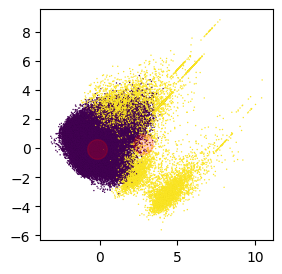

Cluster 0: 179417 points
Cluster 1: 11560 points


In [254]:
best_model_ind_r = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_ind, centroids=best_model_ind_r.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_ind_r.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model_ind_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

## Analysis

#### Original data clustering

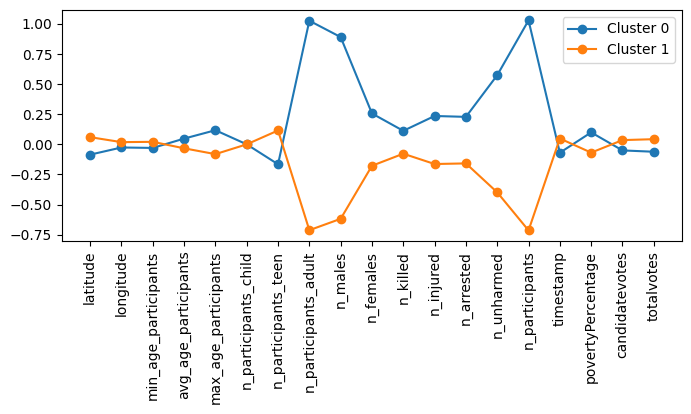

In [279]:
centers = best_model_orig.cluster_centers_
cols = df_orig.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

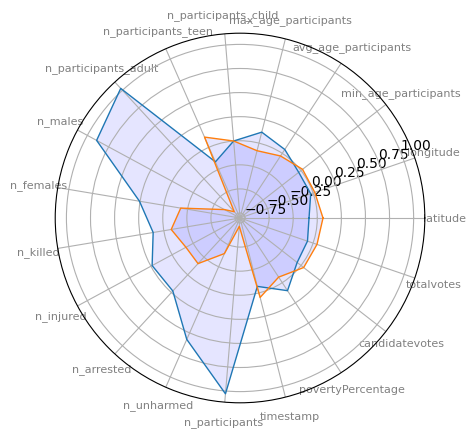

In [280]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [258]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c =  df_init[df_init['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [259]:
party_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         43581       34683
1         65933       46780

In [260]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.556846    0.443154
1  0.584964    0.415036

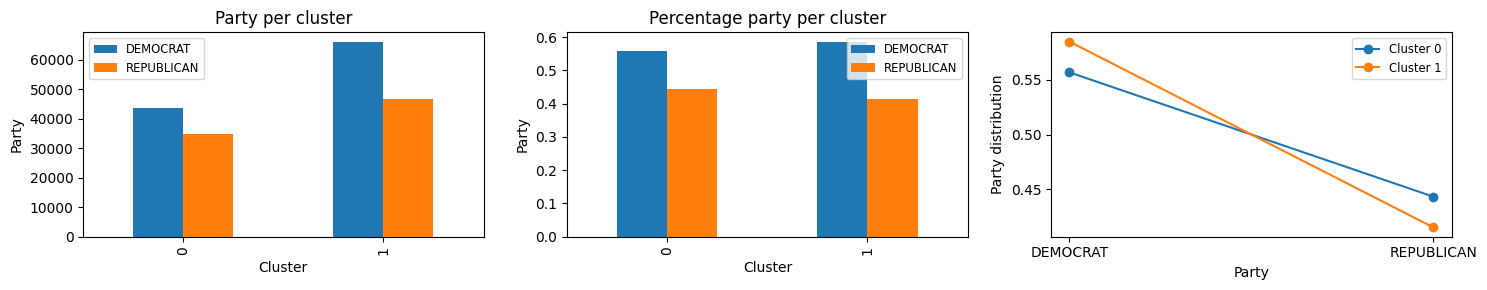

In [261]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [262]:
day_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         2745  2426  2561  2572  2591  2559  2495  2581  2461  2517  ...   
1         4215  3604  3572  3644  3760  3670  3676  3608  3606  3495  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         2551  2519  2538  2657  2635  2603  2511  2424  2316  1613  
1         3530  3717  3518  3818  3718  3784  3812  3519  3490  2203  

[2 rows x 31 columns]

In [263]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.035074  0.030998  0.032723  0.032863  0.033106  0.032697  0.031879   
1  0.037396  0.031975  0.031691  0.032330  0.033359  0.032561  0.032614   

         8         9         10  ...        22        23        24        25  \
0  0.032978  0.031445  0.032160  ...  0.032595  0.032186  0.032429  0.033949   
1  0.032011  0.031993  0.031008  ...  0.031318  0.032978  0.031212  0.033874   

         26        27        28        29        30        31  
0  0.033668  0.033259  0.032084  0.030972  0.029592  0.020610  
1  0.032986  0.033572  0.033820  0.031221  0.030964  0.019545  

[2 rows x 31 columns]

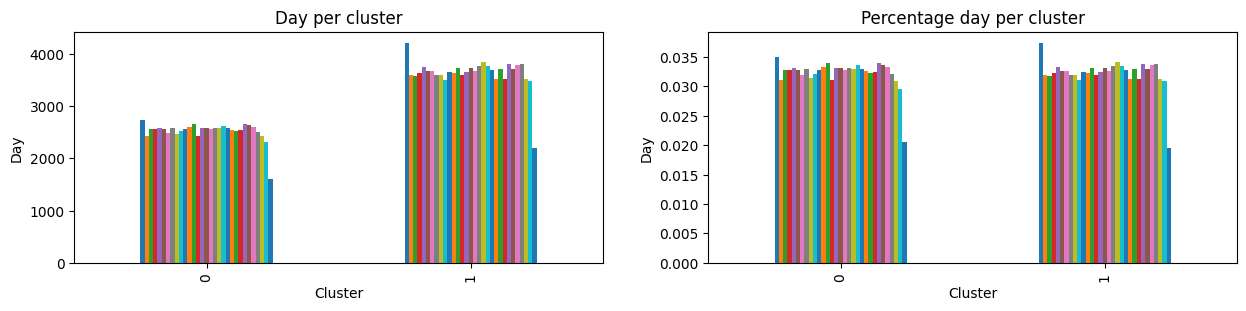

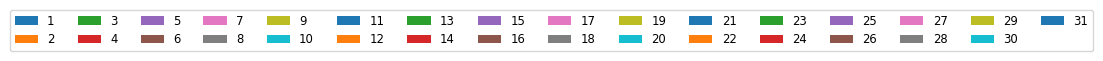

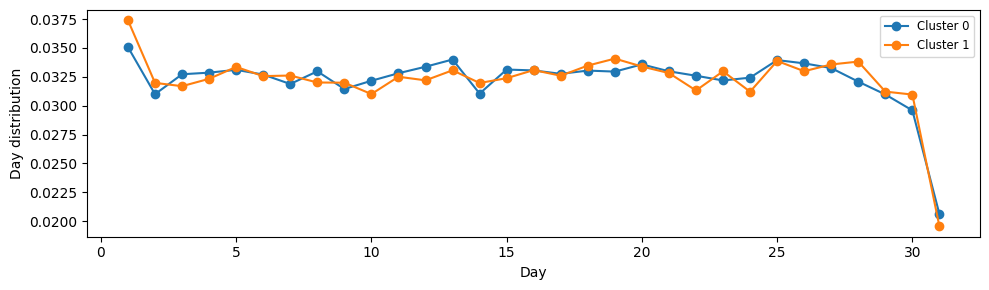

In [264]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [265]:
month_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1     2      3     4     5     6     7     8     9     10  \
row_0                                                                      
0            7632  6133   7360  5921  6495  6035  6747  6851  6358  6503   
1           10878  9110  10915  8619  9105  8529  9704  9828  9050  9315   

date_month    11    12  
row_0                   
0           5951  6278  
1           8422  9238

In [266]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097516  0.078363  0.094041  0.075654  0.082988  0.077111  0.086208   
1  0.096511  0.080825  0.096839  0.076469  0.080780  0.075670  0.086095   

         8         9         10        11        12  
0  0.087537  0.081238  0.083091  0.076038  0.080216  
1  0.087195  0.080292  0.082644  0.074721  0.081960

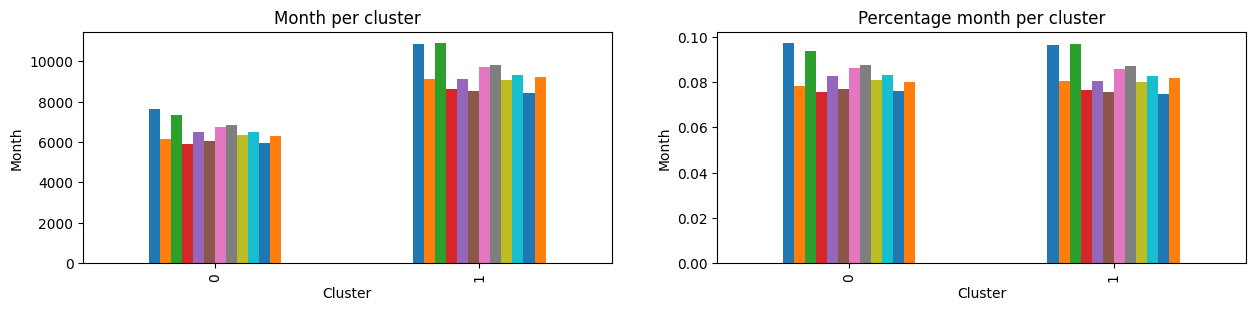

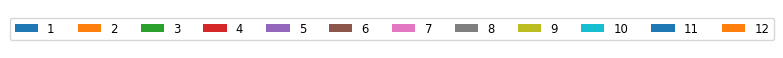

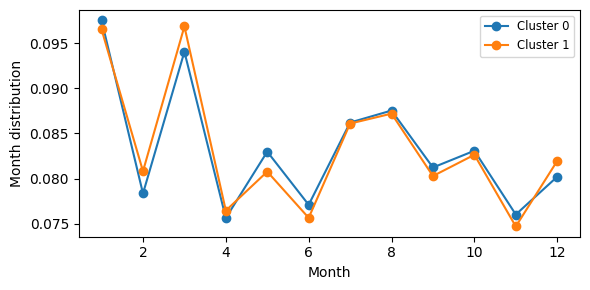

In [267]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [268]:
year_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              24   14796   16498   21530   20892    4524
1              17   16996   22924   31161   34040    7575

In [269]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000307  0.189052  0.210799  0.275095  0.266943  0.057804
1  0.000151  0.150790  0.203384  0.276463  0.302006  0.067206

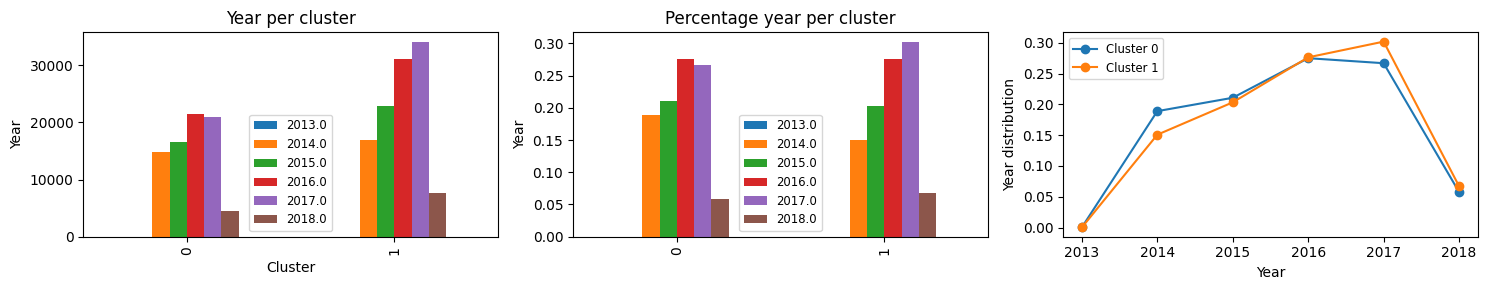

In [270]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [271]:
state_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2004      65      828      1114        3804      1086          933   
1         2333      92     1082      1298        6486      1779         1842   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           404     4844     3368  ...           178       2611   4857   379   
1          1031     6385     3888  ...           312       3537   4673   473   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          155      1869        1217            548       1519      185  
1          230      2981        1606            777       2674      266  

[2 rows x 50 columns]

In [272]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.025606  0.000831  0.01058  0.014234    0.048605  0.013876     0.011921   
1  0.020699  0.000816  0.00960  0.011516    0.057544  0.015783     0.016342   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.005162  0.061893  0.043034  ...      0.002274   0.033361  0.062059   
1  0.009147  0.056648  0.034495  ...      0.002768   0.031381  0.041459   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004843  0.001980  0.023881    0.015550       0.007002   0.019409   
1  0.004196  0.002041  0.026448    0.014249       0.006894   0.023724   

    WYOMING  
0  0.002364  
1  0.002360  

[2 rows x 50 columns]

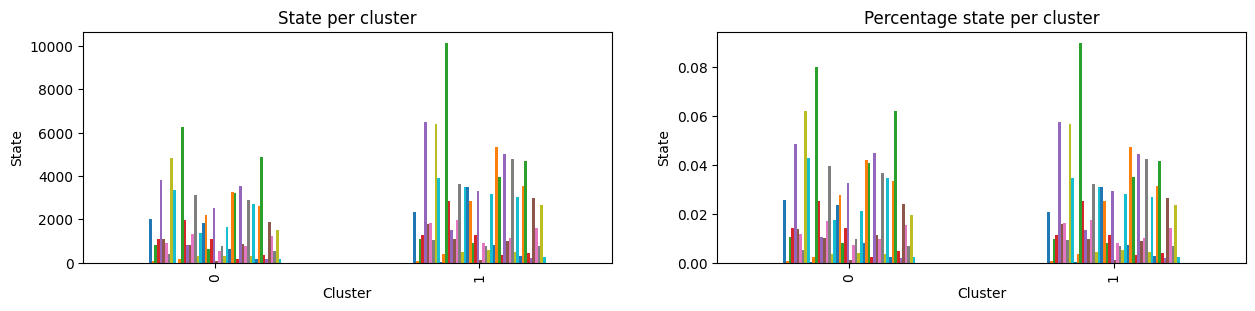

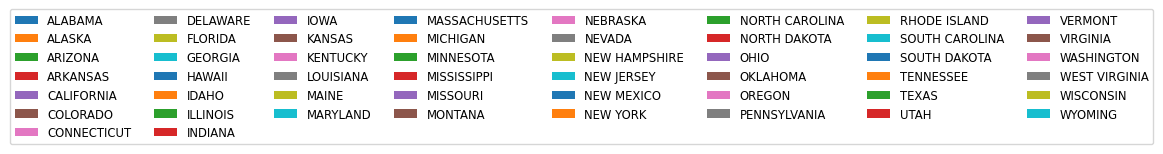

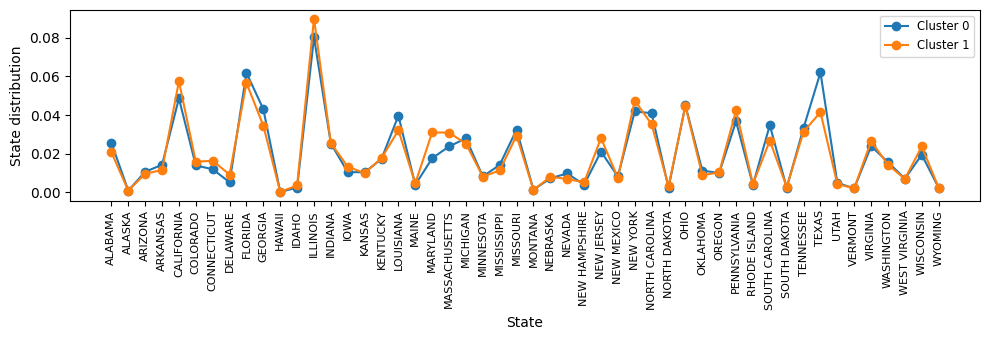

In [273]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [274]:
ic_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   3060                   83   
1                                   2811                  256   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 1                  8   
1                                                 3                 13   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  221                            11   
1                                   37                            17   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     25                140        24   
1                                     11                 52        38   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       294  ...                  92   
1                                       551  ...                 147   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     3               1         256        1   
1                                     1               2         404       29   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        9         827                1   
1                                       62        1171                4   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     274                       1  
1                                     861                       0  

[2 rows x 49 columns]

In [276]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.039098             0.001061                  0.000013   
1       0.024939             0.002271                  0.000027   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000102     0.002824                      0.000141   
1           0.000115     0.000328                      0.000151   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000319           0.001789  0.000307          0.003757  ...   
1       0.000098           0.000461  0.000337          0.004889  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001176      0.000038        0.000013    0.003271  0.000013   
1            0.001304      0.000009        0.000018    0.003584  0.000257   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000115    0.010567         0.000013        0.003501   
1         0.000550    0.010389         0.000035        0.007639   

   UNLAWFUL_PURCHASE_SALE  
0                0.000013  
1                0.000000  

[2 rows x 49 columns]

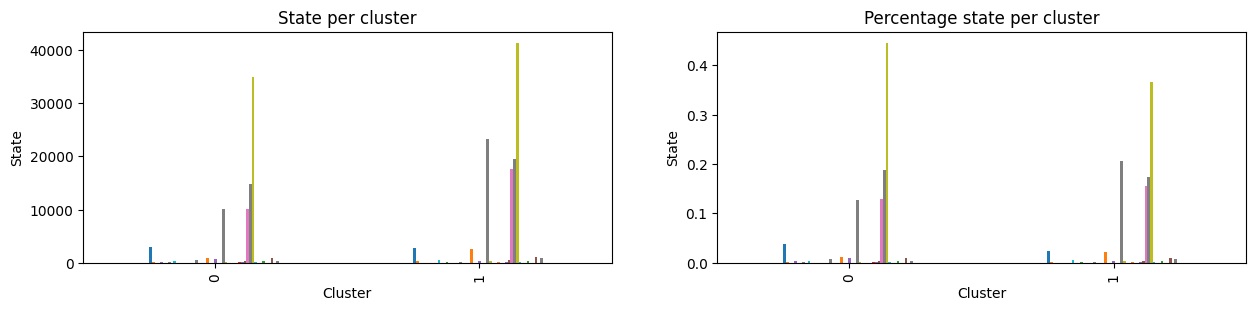

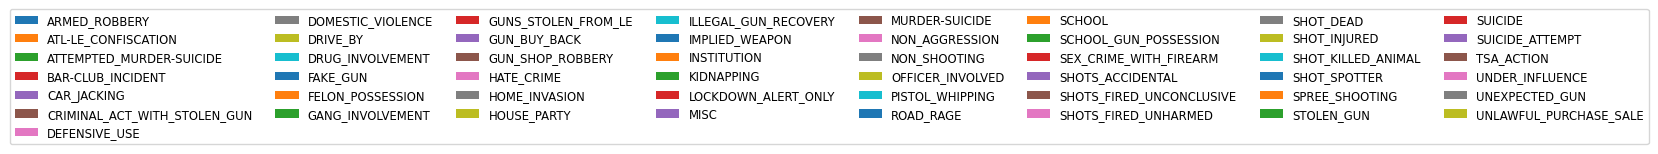

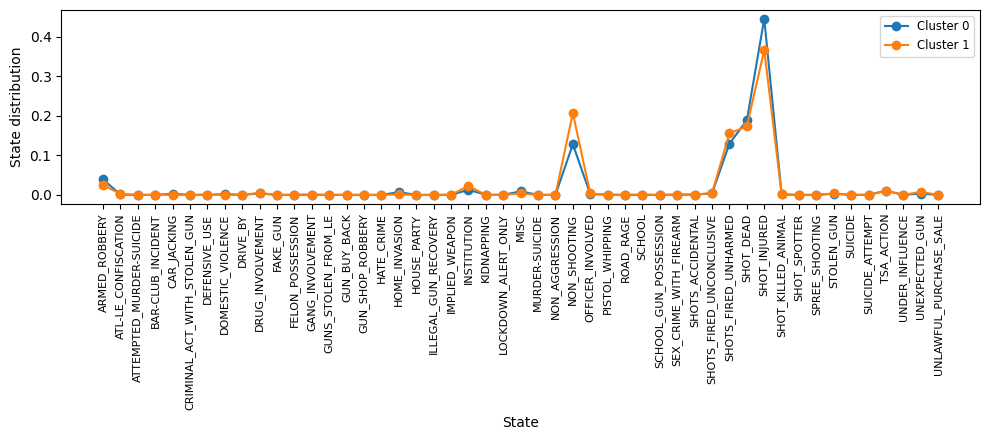

In [277]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced original data clustring

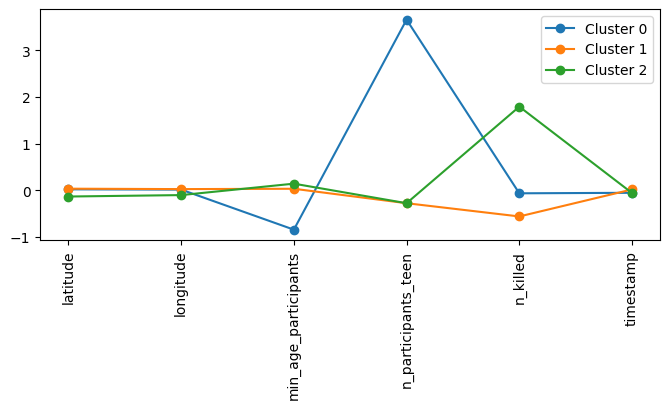

In [283]:
centers = best_model_r_orig.cluster_centers_
cols = reduced_orig.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

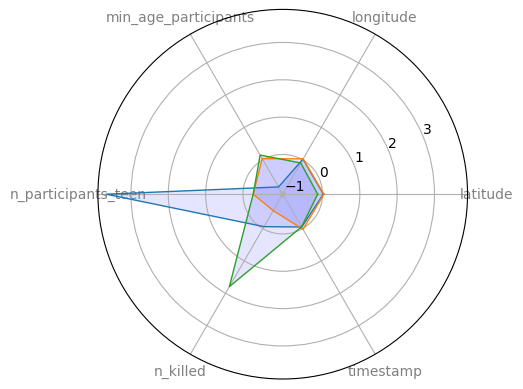

In [284]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [285]:
party_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7929        5334
1         76489       58831
2         25096       17298

In [286]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.597829    0.402171
1  0.565245    0.434755
2  0.591971    0.408029

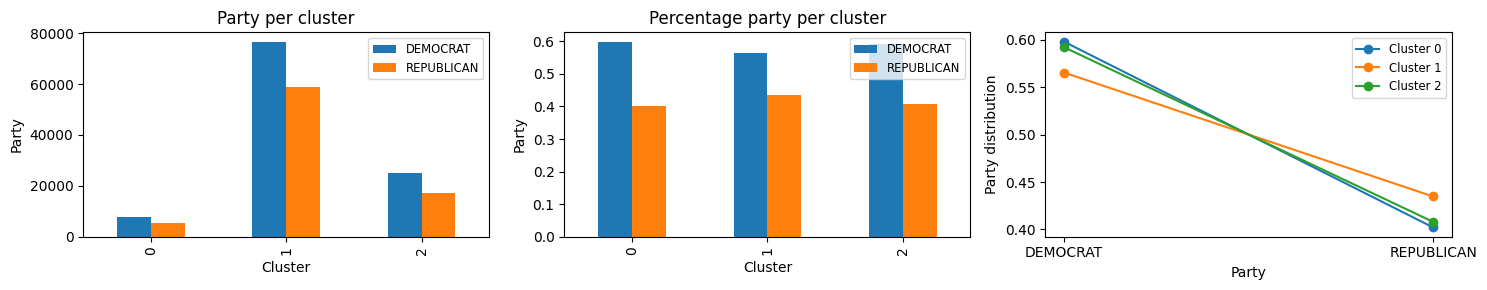

In [287]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [288]:
day_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          488   425   403   409   457   452   421   428   451   406  ...   
1         4990  4292  4384  4381  4495  4361  4376  4385  4277  4212  ...   
2         1482  1313  1346  1426  1399  1416  1374  1376  1339  1394  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          398   433   424   434   425   426   434   416   400   239  
1         4354  4346  4264  4633  4493  4514  4474  4227  4097  2699  
2         1329  1457  1368  1408  1435  1447  1415  1300  1309   878  

[3 rows x 31 columns]

In [289]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   
1  0.036876  0.031717  0.032397  0.032375  0.033218  0.032227  0.032338   
2  0.034958  0.030971  0.031750  0.033637  0.033000  0.033401  0.032410   

         8         9         10  ...        22        23        24        25  \
0  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   
1  0.032405  0.031607  0.031126  ...  0.032176  0.032116  0.031510  0.034237   
2  0.032457  0.031585  0.032882  ...  0.031349  0.034368  0.032269  0.033212   

         26        27        28        29        30        31  
0  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  
1  0.033203  0.033358  0.033062  0.031237  0.030276  0.019945  
2  0.033849  0.034132  0.033377  0.030665  0.030877  0.020710  

[3 rows x 31 columns]

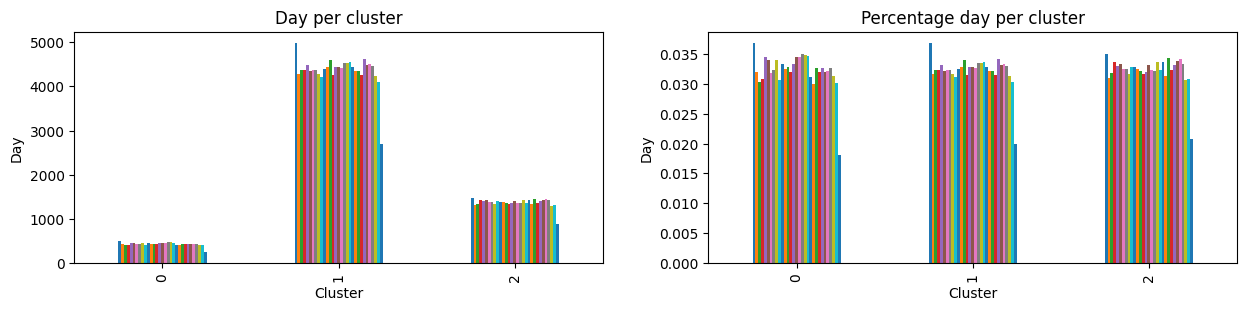

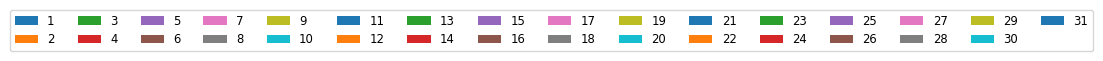

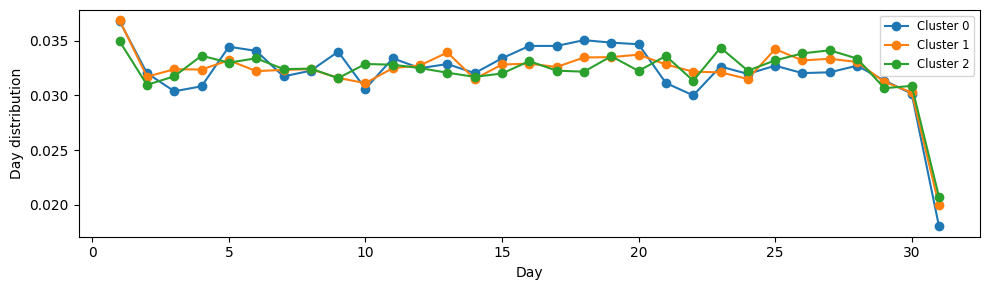

In [290]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [291]:
month_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1287   1101   1249   1026   1113   1000   1127   1134   1058   
1           13097  10781  13107  10415  10974  10231  11607  11904  11012   
2            4126   3361   3919   3099   3513   3333   3717   3641   3338   

date_month     10    11     12  
row_0                           
0            1092  1039   1037  
1           11306  9980  10906  
2            3420  3354   3573

In [292]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   
1  0.096785  0.079670  0.096859  0.076966  0.081097  0.075606  0.085774   
2  0.097325  0.079280  0.092442  0.073100  0.082865  0.078620  0.087678   

         8         9         10        11        12  
0  0.085501  0.079771  0.082334  0.078338  0.078187  
1  0.087969  0.081377  0.083550  0.073751  0.080594  
2  0.085885  0.078738  0.080672  0.079115  0.084281

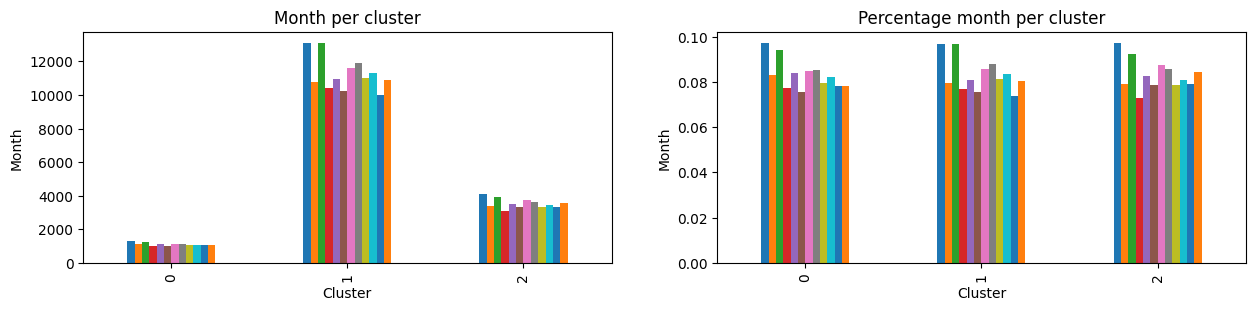

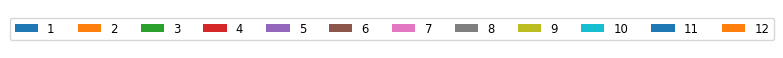

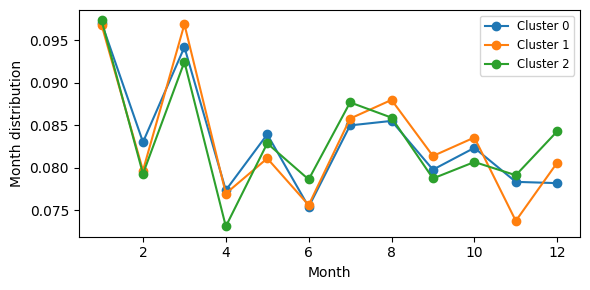

In [293]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [294]:
year_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2450    2869    3408    3697     837
1              23   21525   27366   38030   39705    8671
2              16    7817    9187   11253   11530    2591

In [295]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108
1  0.000170  0.159067  0.202232  0.281038  0.293416  0.064078
2  0.000377  0.184389  0.216705  0.265439  0.271972  0.061117

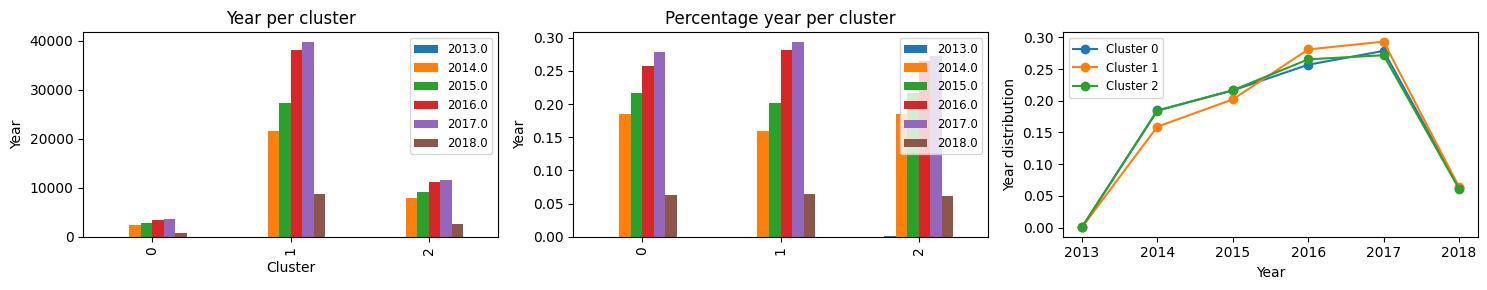

In [296]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [298]:
state_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          256       5      114       173         641       173          146   
1         2773     129     1055      1712        6975      2038         2290   
2         1308      23      741       527        2674       654          339   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           133      820      514  ...            33        497    621    63   
1          1114     7761     4970  ...           375       4305   5895   603   
2           188     2648     1772  ...            82       1346   3014   186   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       414         194             53        307       20  
1          320      3385        2043           1028       3063      330  
2           54      1051         586            244        823      101  

[3 rows x 50 columns]

In [299]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   
1  0.020492  0.000953  0.007796  0.012651    0.051544  0.015061     0.016923   
2  0.030853  0.000543  0.017479  0.012431    0.063075  0.015427     0.007996   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   
1  0.008232  0.057353  0.036728  ...      0.002771   0.031813  0.043563   
2  0.004435  0.062462  0.041798  ...      0.001934   0.031750  0.071095   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004750  0.000829  0.031215    0.014627       0.003996   0.023147   
1  0.004456  0.002365  0.025015    0.015098       0.007597   0.022635   
2  0.004387  0.001274  0.024791    0.013823       0.005756   0.019413   

    WYOMING  
0  0.001508  
1  0.002439  
2  0.002382  

[3 rows x 50 columns]

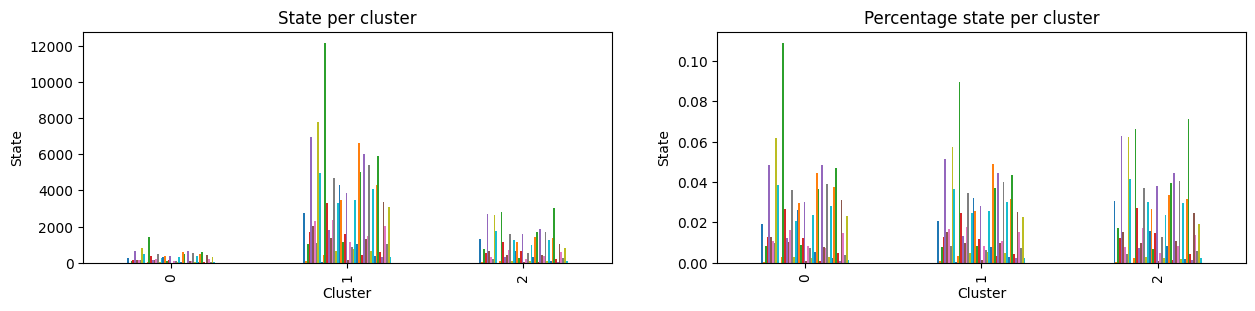

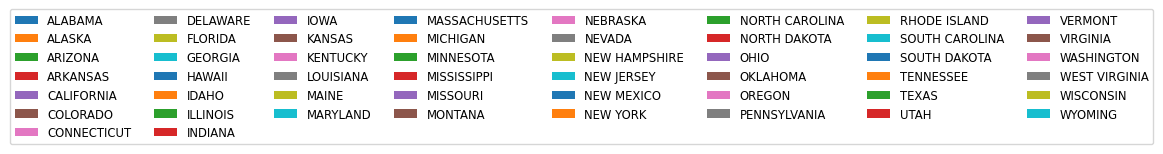

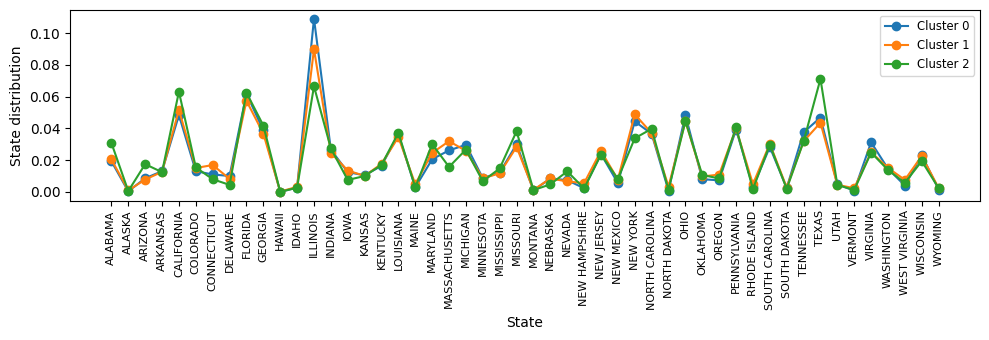

In [300]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [301]:
ic_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    174                   20   
1                                   5605                  307   
2                                     92                   12   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 4                 16   
2                                                 0                  3   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   18                             0   
1                                  232                            27   
2                                    8                             1   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  8         5   
1                                     29                181        53   
2                                      5                  3         4   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        25  ...                   9   
1                                       800  ...                 162   
2                                        20  ...                  68   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          49        1   
1                                     4               3         527        2   
2                                     0               0          84       27   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        3         132                0   
1                                       62        1376                5   
2                                        6         490                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      68                       0  
1                                    1035                       1  
2                                      32                       0  

[3 rows x 49 columns]

In [302]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.013119             0.001508                   0.00000   
1       0.041420             0.002269                   0.00003   
2       0.002170             0.000283                   0.00000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000151     0.001357                      0.000000   
1           0.000118     0.001714                      0.000200   
2           0.000071     0.000189                      0.000024   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000151           0.000603  0.000377          0.001885  ...   
1       0.000214           0.001338  0.000392          0.005912  ...   
2       0.000118           0.000071  0.000094          0.000472  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000679       0.00000        0.000000    0.003694  0.000075   
1            0.001197       0.00003        0.000022    0.003894  0.000015   
2            0.001604       0.00000        0.000000    0.001981  0.000637   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000226    0.009952         0.000000        0.005127   
1         0.000458    0.010168         0.000037        0.007649   
2         0.000142    0.011558         0.000000        0.000755   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000007  
2                0.000000  

[3 rows x 49 columns]

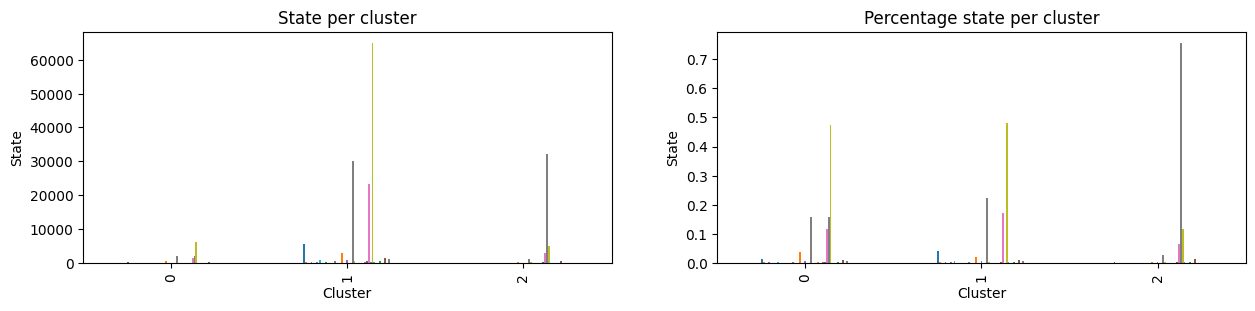

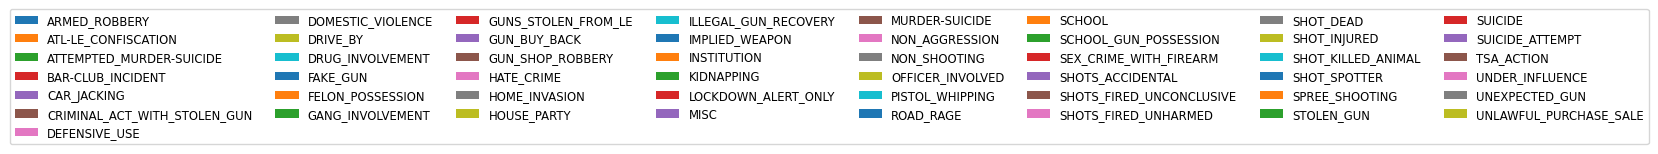

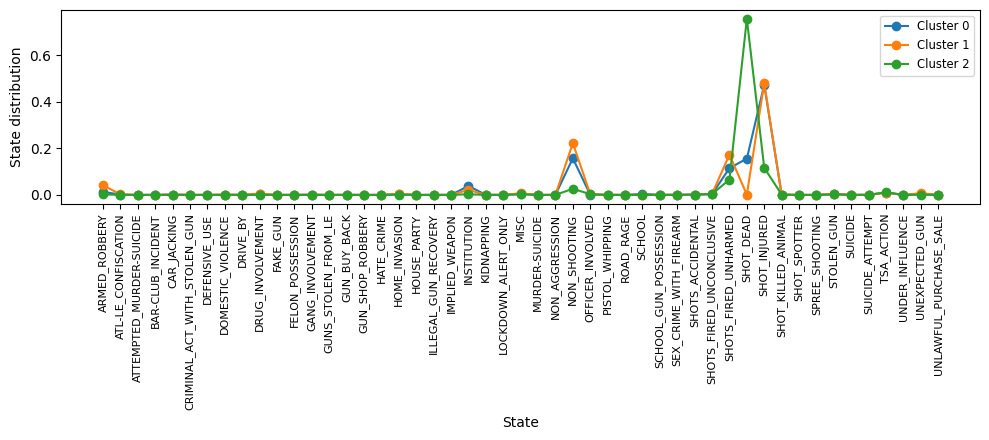

In [303]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Augmented data clustering

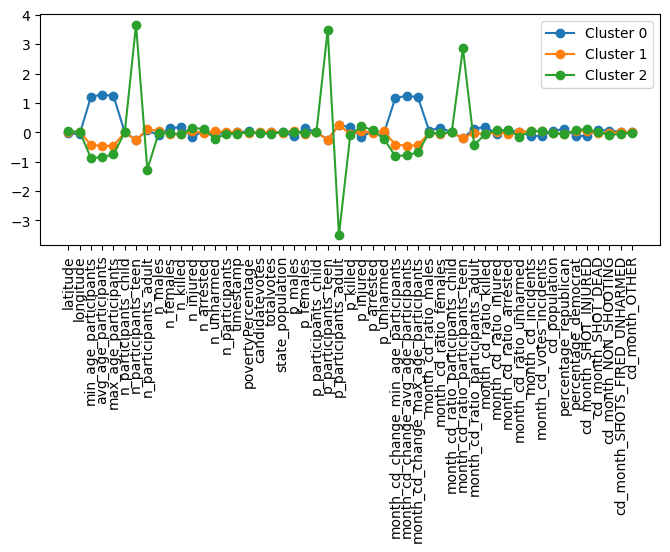

In [305]:
centers = best_model.cluster_centers_
cols = df.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

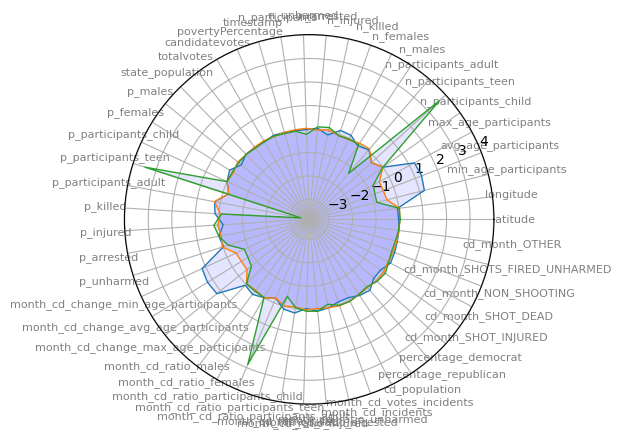

In [307]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [311]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         27720       25854
1         74122       50394
2          7672        5215

In [312]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.517415    0.482585
1  0.595281    0.404719
2  0.595329    0.404671

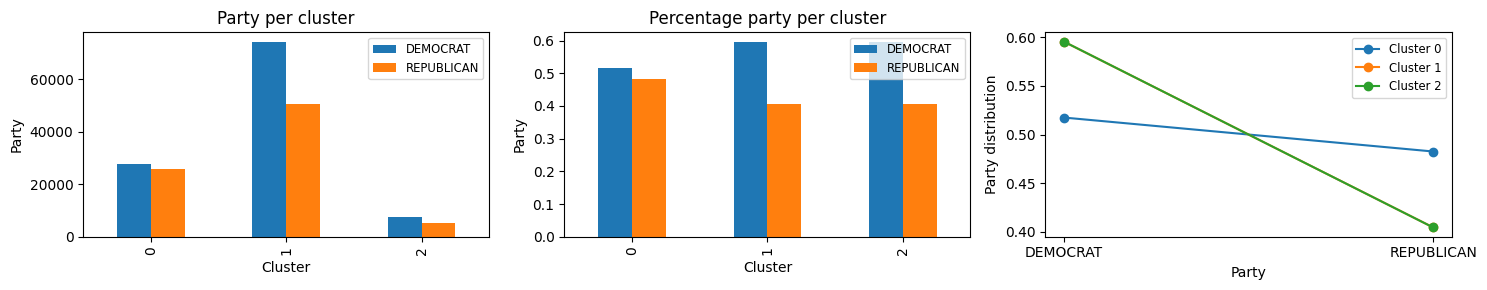

In [313]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [314]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         2008  1702  1786  1793  1742  1800  1696  1700  1664  1723  ...   
1         4479  3914  3953  4029  4163  3991  4069  4072  3961  3901  ...   
2          473   414   394   394   446   438   406   417   442   388  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         1711  1738  1660  1775  1813  1776  1732  1705  1650  1080  
1         3986  4073  3988  4273  4125  4193  4166  3836  3774  2512  
2          384   425   408   427   415   418   425   402   382   224  

[3 rows x 31 columns]

In [315]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.037481  0.031769  0.033337  0.033468  0.032516  0.033598  0.031657   
1  0.035971  0.031434  0.031747  0.032357  0.033433  0.032052  0.032679   
2  0.036704  0.032125  0.030573  0.030573  0.034609  0.033988  0.031505   

         8         9         10  ...        22        23        24        25  \
0  0.031732  0.031060  0.032161  ...  0.031937  0.032441  0.030985  0.033132   
1  0.032703  0.031811  0.031329  ...  0.032012  0.032711  0.032028  0.034317   
2  0.032358  0.034298  0.030108  ...  0.029797  0.032979  0.031660  0.033134   

         26        27        28        29        30        31  
0  0.033841  0.033150  0.032329  0.031825  0.030799  0.020159  
1  0.033128  0.033674  0.033458  0.030807  0.030309  0.020174  
2  0.032203  0.032436  0.032979  0.031194  0.029642  0.017382  

[3 rows x 31 columns]

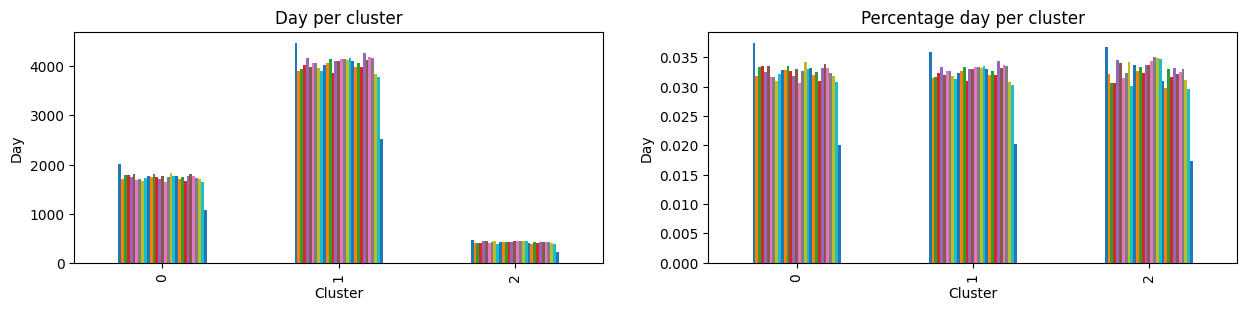

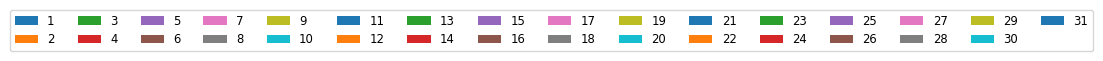

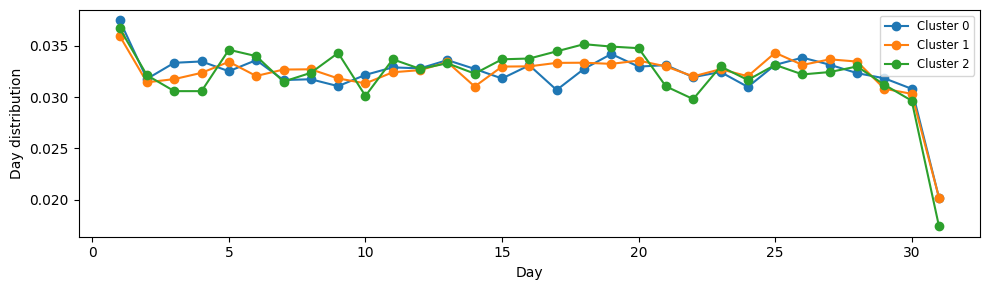

In [316]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [318]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month     1     2      3     4      5     6      7      8      9      10  \
row_0                                                                           
0            5309  4445   5112  4029   4213  4128   4575   4541   4267   4494   
1           11948  9719  11958  9511  10294  9470  10787  11040  10119  10265   
2            1253  1079   1205  1000   1093   966   1089   1098   1022   1059   

date_month    11     12  
row_0                    
0           3961   4500  
1           9398  10007  
2           1014   1009

In [319]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.099097  0.082969  0.095419  0.075204  0.078639  0.077052  0.085396   
1  0.095956  0.078054  0.096036  0.076384  0.082672  0.076054  0.086631   
2  0.097230  0.083728  0.093505  0.077598  0.084814  0.074959  0.084504   

         8         9         10        11        12  
0  0.084761  0.079647  0.083884  0.073935  0.083996  
1  0.088663  0.081267  0.082439  0.075476  0.080367  
2  0.085202  0.079305  0.082176  0.078684  0.078296

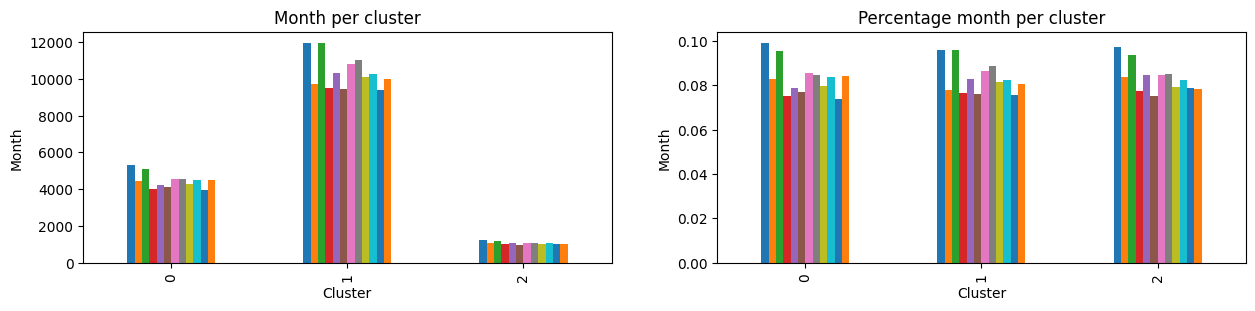

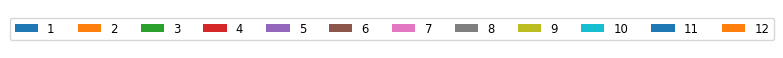

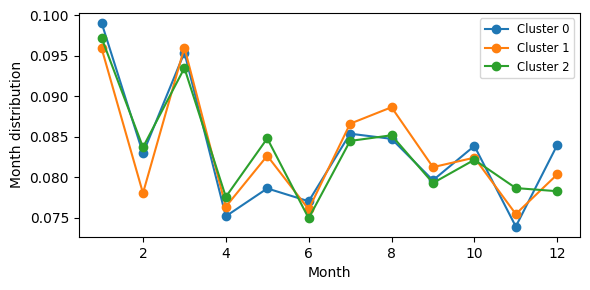

In [320]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [321]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              15    8857   11341   14506   15394    3461
1              24   20577   25279   34883   35935    7818
2               2    2358    2802    3302    3603     820

In [322]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000280  0.165323  0.211689  0.270766  0.287341  0.064602
1  0.000193  0.165256  0.203018  0.280149  0.288597  0.062787
2  0.000155  0.182975  0.217428  0.256227  0.279584  0.063630

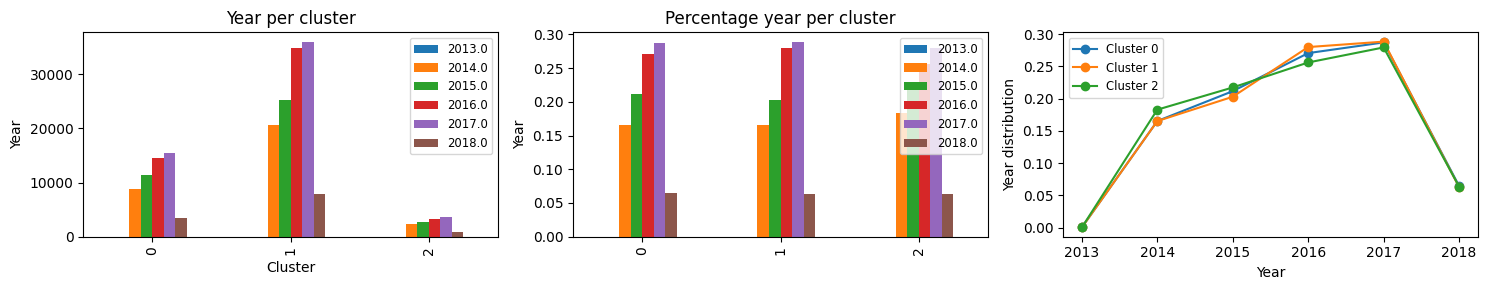

In [323]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [324]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         1313      38      640       761        3221       870          746   
1         2773     114     1161      1481        6444      1829         1891   
2          251       5      109       170         625       166          138   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           309     3291     2099  ...           161       1688   3019   257   
1           996     7151     4654  ...           297       3982   5901   532   
2           130      787      503  ...            32        478    610    63   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          122      1280         917            454       1101      158  
1          252      3164        1716            820       2796      273  
2           11       406         190             51        296       20  

[3 rows x 50 columns]

In [325]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.024508  0.000709  0.011946  0.014205    0.060122  0.016239     0.013925   
1  0.022270  0.000916  0.009324  0.011894    0.051752  0.014689     0.015187   
2  0.019477  0.000388  0.008458  0.013192    0.048498  0.012881     0.010708   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.005768  0.061429  0.039179  ...      0.003005   0.031508  0.056352   
1  0.007999  0.057430  0.037377  ...      0.002385   0.031980  0.047391   
2  0.010088  0.061069  0.039032  ...      0.002483   0.037092  0.047335   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004797  0.002277  0.023892    0.017117       0.008474   0.020551   
1  0.004273  0.002024  0.025410    0.013781       0.006585   0.022455   
2  0.004889  0.000854  0.031505    0.014744       0.003957   0.022969   

    WYOMING  
0  0.002949  
1  0.002192  
2  0.001552  

[3 rows x 50 columns]

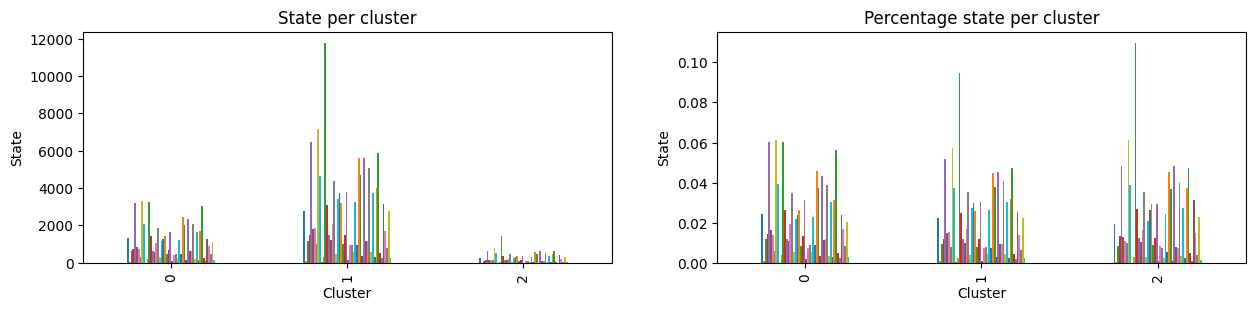

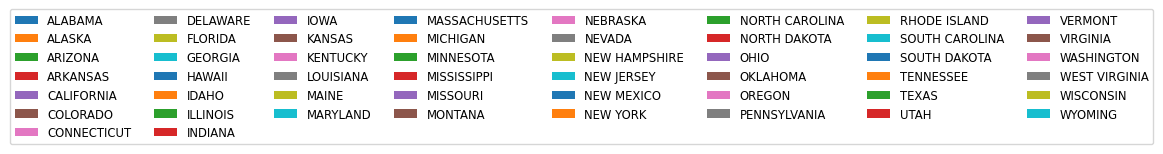

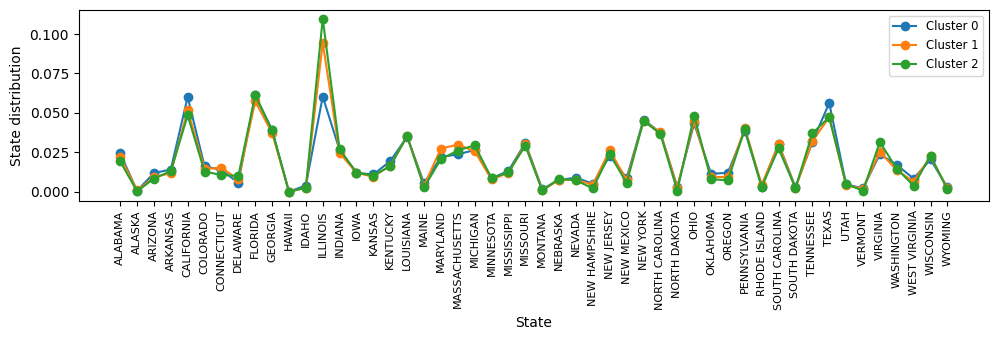

In [326]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [327]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   1487                   93   
1                                   4219                  227   
2                                    165                   19   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 2                  6   
1                                                 2                 13   
2                                                 0                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   80                             4   
1                                  162                            24   
2                                   16                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     10                 90        14   
1                                     24                 95        43   
2                                      2                  7         5   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       228  ...                  81   
1                                       594  ...                 149   
2                                        23  ...                   9   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0         166       12   
1                                     4               3         446       17   
2                                     0               0          48        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       33         550                2   
1                                       36        1321                3   
2                                        2         127                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     267                       0  
1                                     802                       1  
2                                      66                       0  

[3 rows x 49 columns]

In [328]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.027756             0.001736                  0.000037   
1       0.033883             0.001823                  0.000016   
2       0.012804             0.001474                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000112     0.001493                      0.000075   
1           0.000104     0.001301                      0.000193   
2           0.000155     0.001242                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000187           0.001680  0.000261          0.004256  ...   
1       0.000193           0.000763  0.000345          0.004770  ...   
2       0.000155           0.000543  0.000388          0.001785  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001512      0.000000        0.000000    0.003099  0.000224   
1            0.001197      0.000032        0.000024    0.003582  0.000137   
2            0.000698      0.000000        0.000000    0.003725  0.000078   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000616    0.010266         0.000037        0.004984   
1         0.000289    0.010609         0.000024        0.006441   
2         0.000155    0.009855         0.000000        0.005121   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000008  
2                0.000000  

[3 rows x 49 columns]

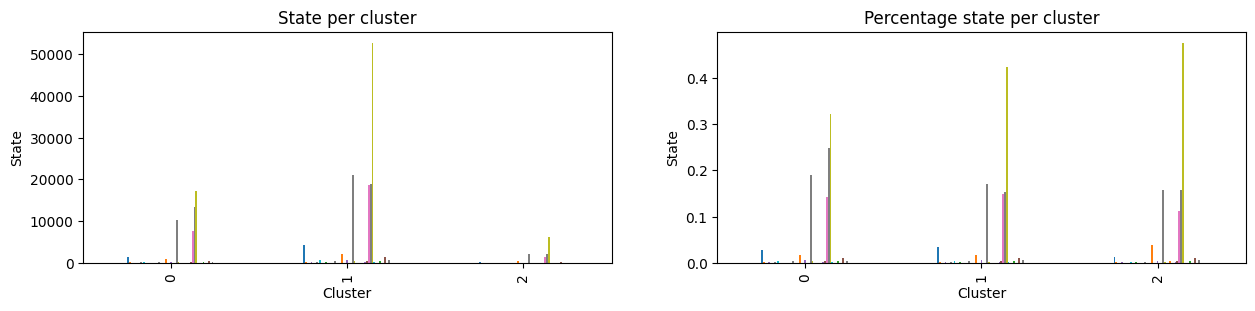

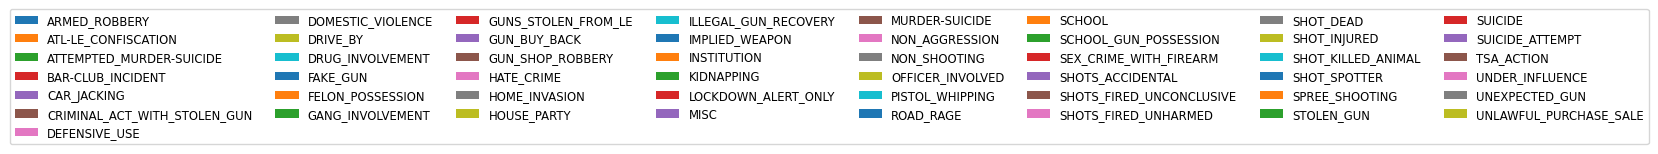

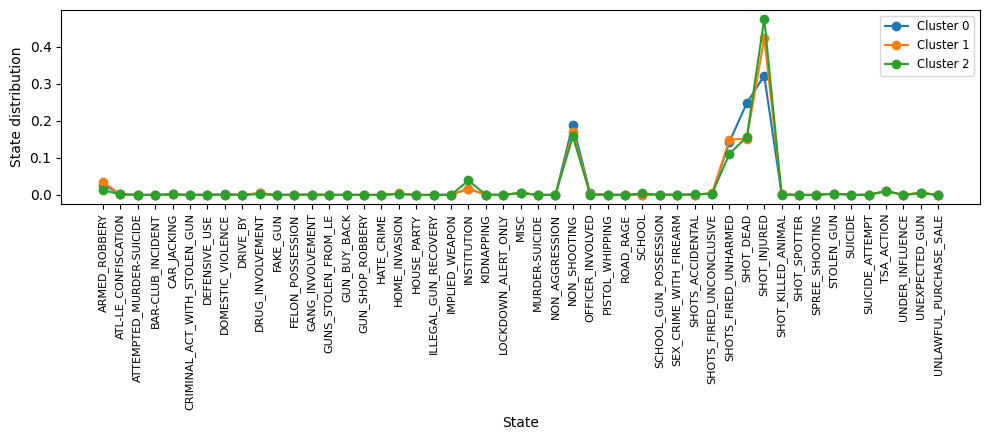

In [329]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced augmented data clustering

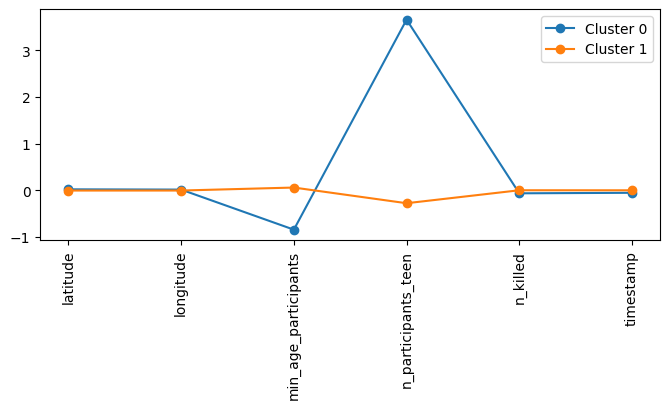

In [332]:
centers = best_model_r.cluster_centers_
cols = reduced.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

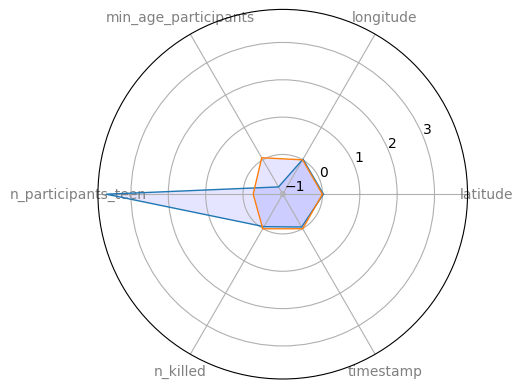

In [333]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [334]:
party_xt_pct = pd.crosstab(best_model_r.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7929        5334
1        101585       76129

In [335]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.597829    0.402171
1  0.571621    0.428379

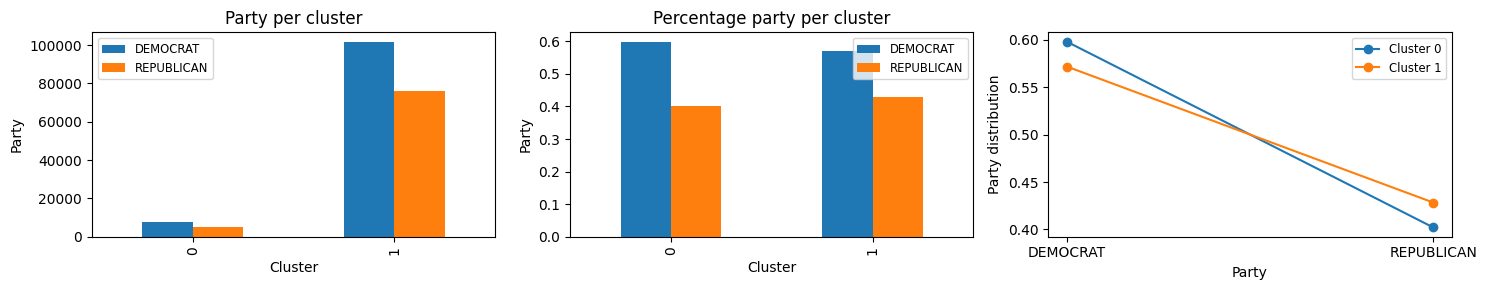

In [336]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [337]:
day_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          488   425   403   409   457   452   421   428   451   406  ...   
1         6472  5605  5730  5807  5894  5777  5750  5761  5616  5606  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          398   433   424   434   425   426   434   416   400   239  
1         5683  5803  5632  6041  5928  5961  5889  5527  5406  3577  

[2 rows x 31 columns]

In [338]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   
1  0.036418  0.031539  0.032243  0.032676  0.033166  0.032507  0.032355   

         8         9         10  ...        22        23        24        25  \
0  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   
1  0.032417  0.031601  0.031545  ...  0.031978  0.032654  0.031691  0.033993   

         26        27        28        29        30        31  
0  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  
1  0.033357  0.033543  0.033138  0.031101  0.030420  0.020128  

[2 rows x 31 columns]

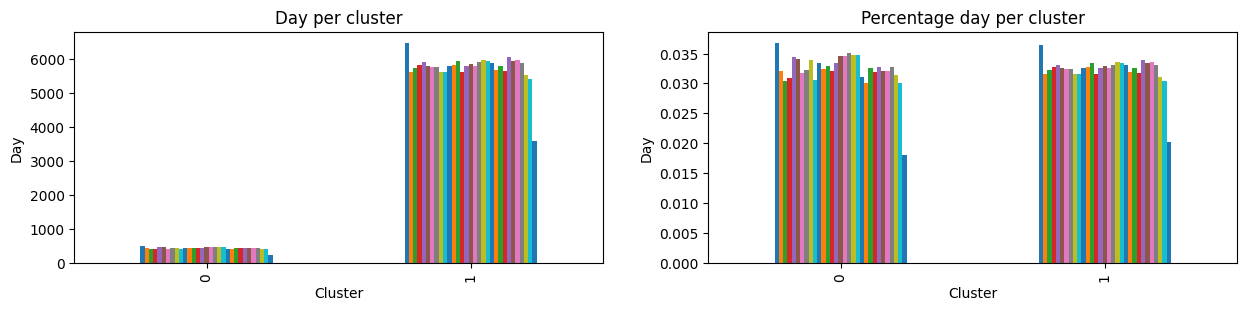

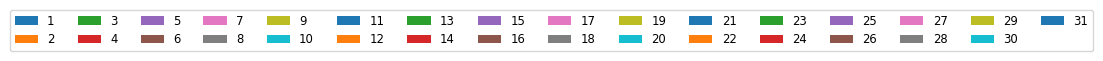

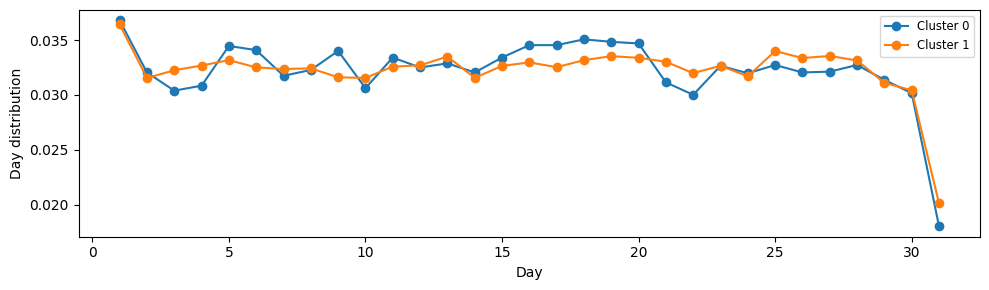

In [339]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [340]:
month_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1287   1101   1249   1026   1113   1000   1127   1134   1058   
1           17223  14142  17026  13514  14487  13564  15324  15545  14350   

date_month     10     11     12  
row_0                            
0            1092   1039   1037  
1           14726  13334  14479

In [341]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   
1  0.096914  0.079577  0.095806  0.076044  0.081519  0.076325  0.086228   

         8         9         10        11        12  
0  0.085501  0.079771  0.082334  0.078338  0.078187  
1  0.087472  0.080748  0.082863  0.075031  0.081474

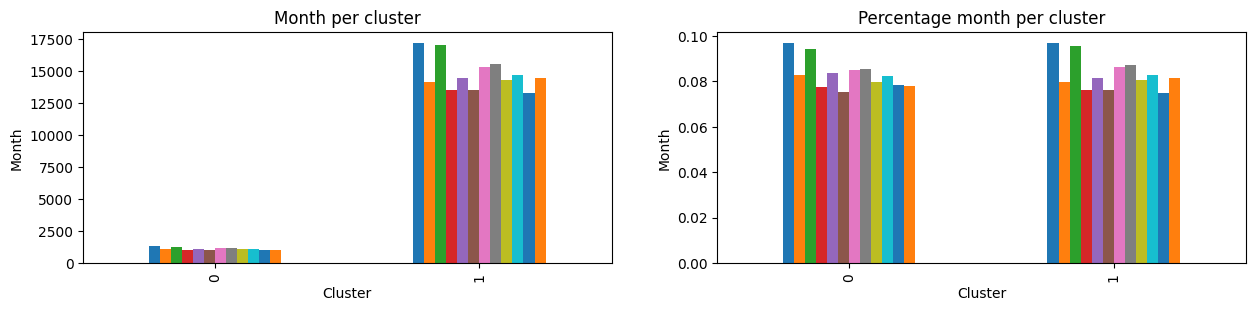

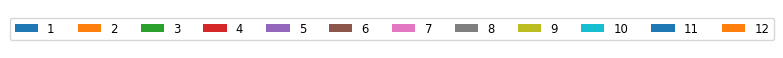

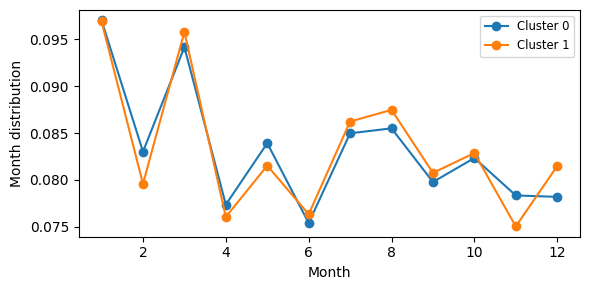

In [342]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [343]:
year_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2450    2869    3408    3697     837
1              39   29342   36553   49283   51235   11262

In [344]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108
1  0.000219  0.165108  0.205684  0.277316  0.288300  0.063371

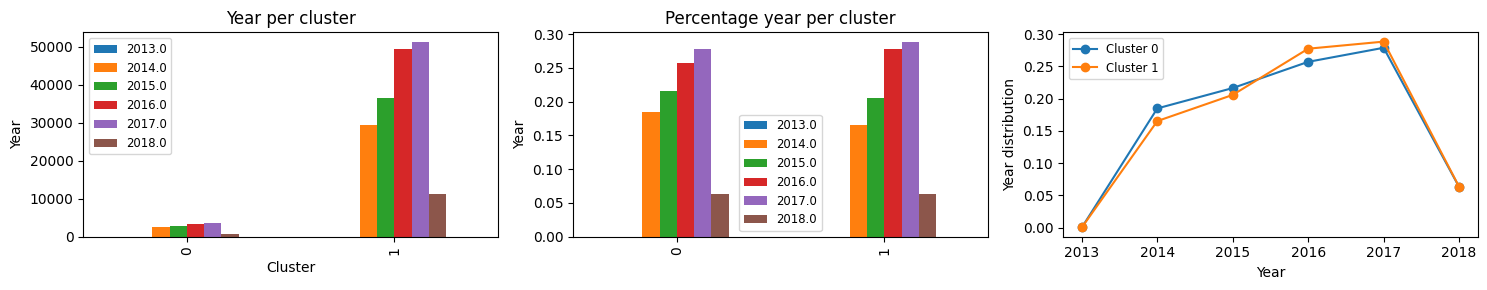

In [345]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [346]:
state_xt_pct = pd.crosstab(best_model_r.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          256       5      114       173         641       173          146   
1         4081     152     1796      2239        9649      2692         2629   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           133      820      514  ...            33        497    621    63   
1          1302    10409     6742  ...           457       5651   8909   789   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       414         194             53        307       20  
1          374      4436        2629           1272       3886      431  

[2 rows x 50 columns]

In [347]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   
1  0.022964  0.000855  0.010106  0.012599    0.054295  0.015148     0.014793   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   
1  0.007326  0.058572  0.037937  ...      0.002572   0.031798  0.050131   

      UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN   WYOMING  
0  0.00475  0.000829  0.031215    0.014627       0.003996   0.023147  0.001508  
1  0.00444  0.002105  0.024961    0.014793       0.007158   0.021867  0.002425  

[2 rows x 50 columns]

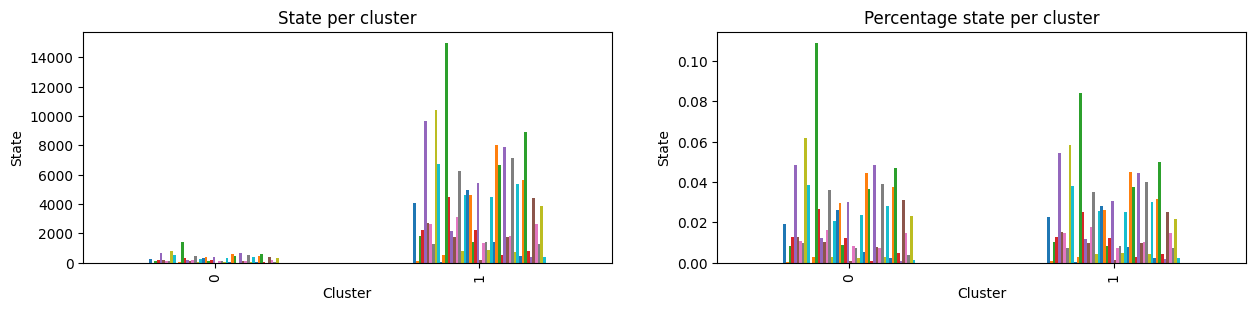

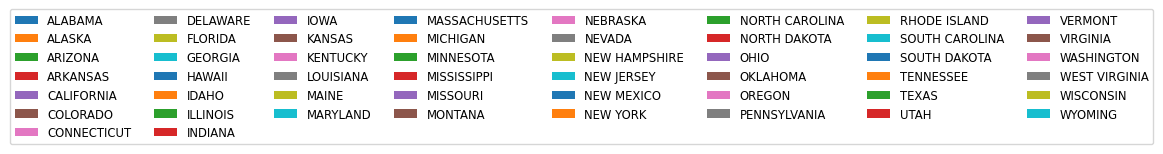

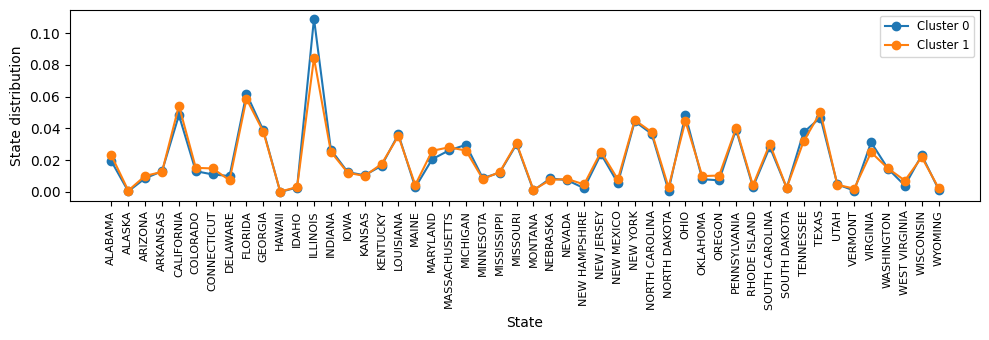

In [348]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [349]:
ic_xt_pct = pd.crosstab(best_model_r.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    174                   20   
1                                   5697                  319   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 4                 19   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   18                             0   
1                                  240                            28   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  8         5   
1                                     34                184        57   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        25  ...                   9   
1                                       820  ...                 230   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          49        1   
1                                     4               3         611       29   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        3         132                0   
1                                       68        1866                5   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      68                       0  
1                                    1067                       1  

[2 rows x 49 columns]

In [350]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.013119             0.001508                  0.000000   
1       0.032057             0.001795                  0.000023   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000151     0.001357                      0.000000   
1           0.000107     0.001350                      0.000158   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000151           0.000603  0.000377          0.001885  ...   
1       0.000191           0.001035  0.000321          0.004614  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000679      0.000000        0.000000    0.003694  0.000075   
1            0.001294      0.000023        0.000017    0.003438  0.000163   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000226    0.009952         0.000000        0.005127   
1         0.000383    0.010500         0.000028        0.006004   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000006  

[2 rows x 49 columns]

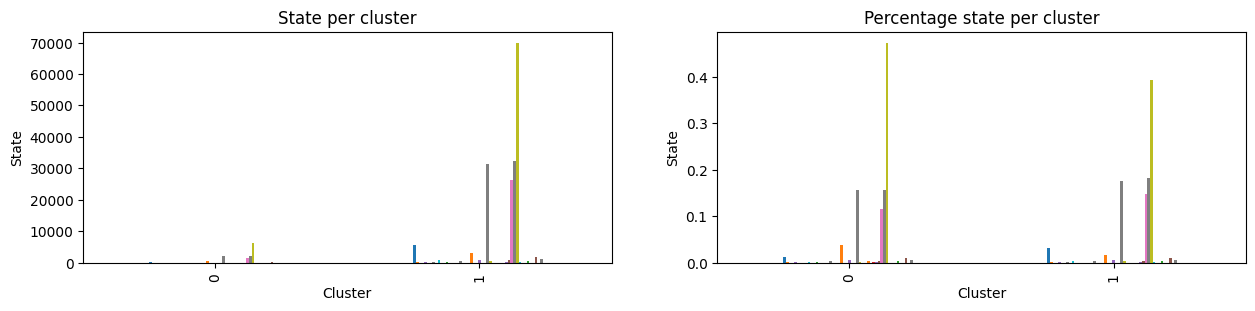

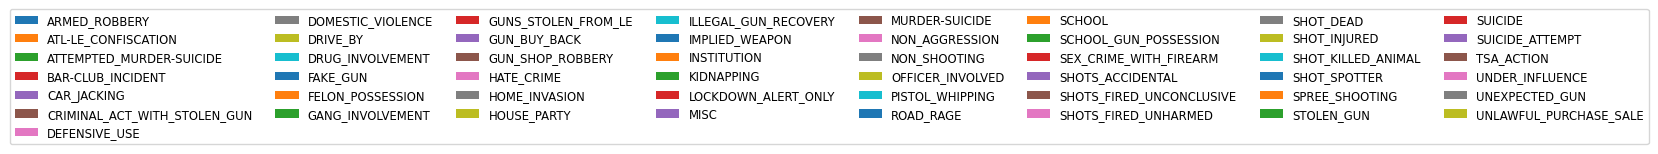

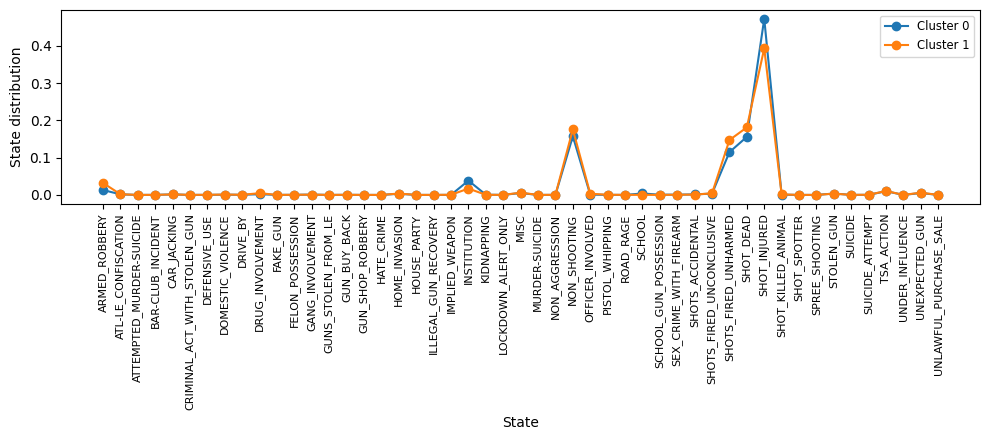

In [351]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators clustering

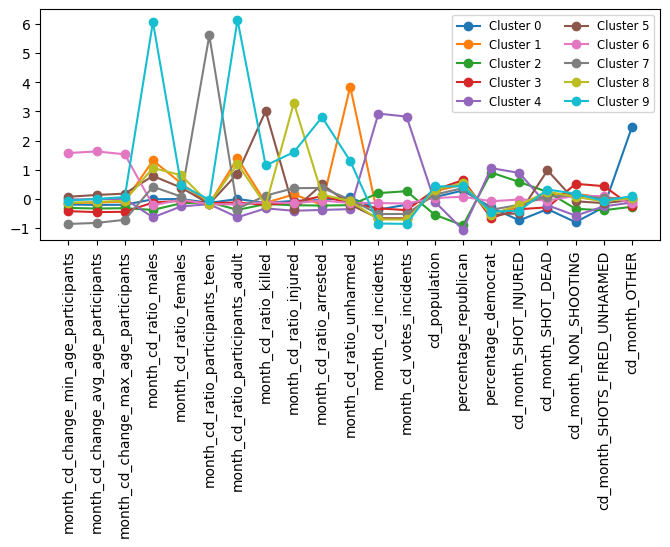

In [359]:
centers = best_model_ind.cluster_centers_
cols = df_ind.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend(fontsize='small', ncol=2)
plt.show()

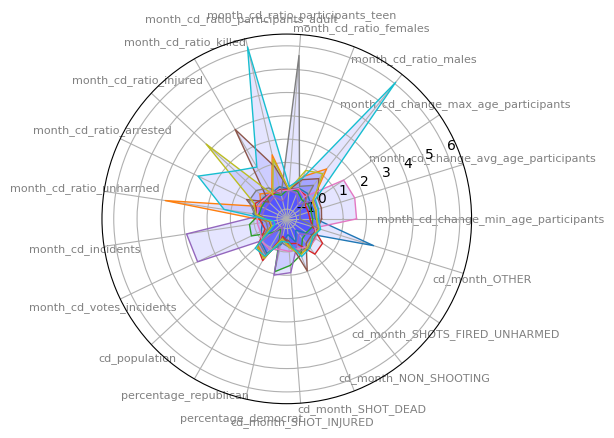

In [361]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [362]:
party_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          6087        6990
1          2470        4361
2         47625        1186
3         15781       40396
4         12760           4
5          3145        6182
6         16373       13257
7          1927        2808
8          2483        4883
9           863        1396

In [363]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.465474    0.534526
1  0.361587    0.638413
2  0.975702    0.024298
3  0.280916    0.719084
4  0.999687    0.000313
5  0.337193    0.662807
6  0.552582    0.447418
7  0.406969    0.593031
8  0.337089    0.662911
9  0.382027    0.617973

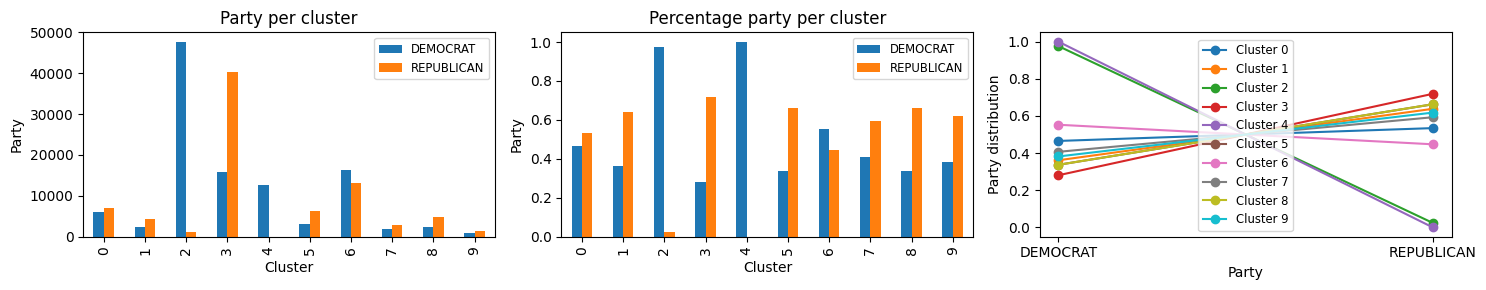

In [364]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [365]:
day_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          525   407   417   427   433   433   415   433   362   429  ...   
1          227   219   232   234   210   229   228   233   213   215  ...   
2         1721  1532  1564  1608  1637  1543  1589  1544  1555  1537  ...   
3         2097  1790  1769  1797  1865  1824  1800  1861  1852  1734  ...   
4          440   395   375   395   435   423   418   398   397   424  ...   
5          319   294   293   317   321   293   310   318   316   282  ...   
6         1112   925   987  1011   969  1009   951   951   897   962  ...   
7          156   180   149   132   164   164   139   155   158   123  ...   
8          276   228   260   225   234   245   248   237   229   219  ...   
9           87    60    87    70    83    66    73    59    88    87  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          393   404   415   472   440   444   428   411   375   235  
1          217   208   204   236   241   204   226   204   214   137  
2         1491  1637  1552  1640  1540  1595  1596  1545  1509   983  
3         1833  1802  1744  1915  1882  1915  1870  1745  1689  1121  
4          407   423   459   469   437   429   409   390   416   263  
5          308   328   293   329   312   330   319   270   301   182  
6          940   950   952   961   985   997   983   947   901   613  
7          154   152   131   159   167   161   179   139   122    83  
8          230   253   242   231   279   241   233   212   207   154  
9          108    79    64    63    70    71    80    80    72    45  

[10 rows x 31 columns]

In [366]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.040147  0.031123  0.031888  0.032653  0.033112  0.033112  0.031735   
1  0.033231  0.032060  0.033963  0.034256  0.030742  0.033524  0.033377   
2  0.035258  0.031386  0.032042  0.032943  0.033538  0.031612  0.032554   
3  0.037328  0.031864  0.031490  0.031988  0.033199  0.032469  0.032042   
4  0.034472  0.030946  0.029380  0.030946  0.034080  0.033140  0.032748   
5  0.034202  0.031521  0.031414  0.033987  0.034416  0.031414  0.033237   
6  0.037530  0.031218  0.033311  0.034121  0.032703  0.034053  0.032096   
7  0.032946  0.038015  0.031468  0.027878  0.034636  0.034636  0.029356   
8  0.037469  0.030953  0.035297  0.030546  0.031768  0.033261  0.033668   
9  0.038513  0.026560  0.038513  0.030987  0.036742  0.029216  0.032315   

         8         9         10  ...        22        23        24        25  \
0  0.033112  0.027682  0.032806  ...  0.030053  0.030894  0.031735  0.036094   
1  0.034109  0.031181  0.031474  ...  0.031767  0.030449  0.029864  0.034548   
2  0.031632  0.031858  0.031489  ...  0.030546  0.033538  0.031796  0.033599   
3  0.033127  0.032967  0.030867  ...  0.032629  0.032077  0.031045  0.034089   
4  0.031181  0.031103  0.033218  ...  0.031887  0.033140  0.035961  0.036744   
5  0.034095  0.033880  0.030235  ...  0.033022  0.035167  0.031414  0.035274   
6  0.032096  0.030273  0.032467  ...  0.031725  0.032062  0.032130  0.032433   
7  0.032735  0.033369  0.025977  ...  0.032524  0.032101  0.027666  0.033580   
8  0.032175  0.031089  0.029731  ...  0.031225  0.034347  0.032854  0.031360   
9  0.026118  0.038955  0.038513  ...  0.047809  0.034971  0.028331  0.027888   

         26        27        28        29        30        31  
0  0.033647  0.033953  0.032729  0.031429  0.028676  0.017970  
1  0.035280  0.029864  0.033084  0.029864  0.031328  0.020056  
2  0.031550  0.032677  0.032698  0.031653  0.030915  0.020139  
3  0.033501  0.034089  0.033288  0.031063  0.030066  0.019955  
4  0.034237  0.033610  0.032043  0.030555  0.032592  0.020605  
5  0.033451  0.035381  0.034202  0.028948  0.032272  0.019513  
6  0.033243  0.033648  0.033176  0.031961  0.030408  0.020688  
7  0.035269  0.034002  0.037804  0.029356  0.025766  0.017529  
8  0.037877  0.032718  0.031632  0.028781  0.028102  0.020907  
9  0.030987  0.031430  0.035414  0.035414  0.031873  0.019920  

[10 rows x 31 columns]

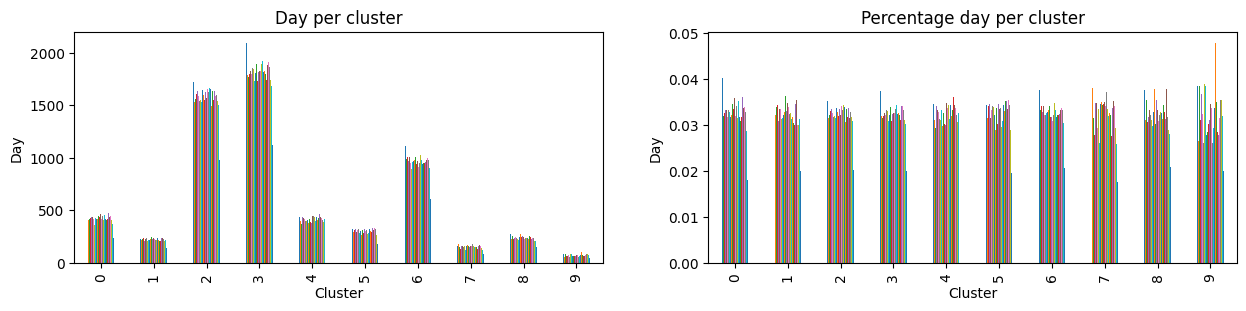

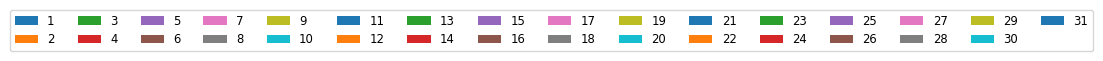

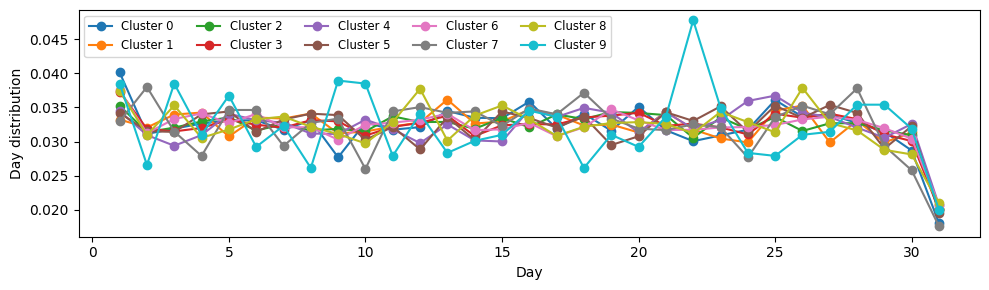

In [373]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [368]:
month_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_month'])
month_xt_pct

date_month    1     2     3     4     5     6     7     8     9     10    11  \
row_0                                                                          
0           1402   953  1015   934   937  1038  1292  1488  1515  1410   780   
1            697   666   681   544   489   524   533   510   531   524   584   
2           4658  3681  4358  3677  3992  3701  4313  4487  3914  3943  3895   
3           5576  4584  5724  4303  4600  4179  4671  4586  4239  4376  4285   
4            832   579  1323  1061  1316  1074  1369  1223  1062  1292   714   
5            972   918   957   664   699   749   669   705   737   739   739   
6           2976  2347  2821  2260  2414  2238  2555  2572  2274  2399  2219   
7            472   474   443   374   391   331   349   365   373   380   405   
8            721   758   730   538   593   537   562   592   577   568   596   
9            204   283   223   185   169   193   138   151   186   187   156   

date_month    12  
row_0             
0            313  
1            548  
2           4192  
3           5054  
4            919  
5            779  
6           2555  
7            378  
8            594  
9            184

In [369]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.107211  0.072876  0.077617  0.071423  0.071653  0.079376  0.098799   
1  0.102035  0.097497  0.099693  0.079637  0.071585  0.076709  0.078027   
2  0.095429  0.075413  0.089283  0.075331  0.081785  0.075823  0.088361   
3  0.099258  0.081599  0.101892  0.076597  0.081884  0.074390  0.083148   
4  0.065183  0.045362  0.103651  0.083124  0.103102  0.084143  0.107255   
5  0.104214  0.098424  0.102605  0.071191  0.074944  0.080304  0.071727   
6  0.100439  0.079210  0.095208  0.076274  0.081471  0.075532  0.086230   
7  0.099683  0.100106  0.093559  0.078986  0.082577  0.069905  0.073706   
8  0.097882  0.102905  0.099104  0.073038  0.080505  0.072903  0.076296   
9  0.090305  0.125277  0.098716  0.081895  0.074812  0.085436  0.061089   

         8         9         10        11        12  
0  0.113788  0.115852  0.107823  0.059647  0.023935  
1  0.074660  0.077734  0.076709  0.085493  0.080223  
2  0.091926  0.080187  0.080781  0.079798  0.085882  
3  0.081635  0.075458  0.077897  0.076277  0.089966  
4  0.095816  0.083203  0.101222  0.055939  0.071999  
5  0.075587  0.079018  0.079232  0.079232  0.083521  
6  0.086804  0.076747  0.080965  0.074890  0.086230  
7  0.077086  0.078775  0.080253  0.085533  0.079831  
8  0.080369  0.078333  0.077111  0.080912  0.080641  
9  0.066844  0.082337  0.082780  0.069057  0.081452

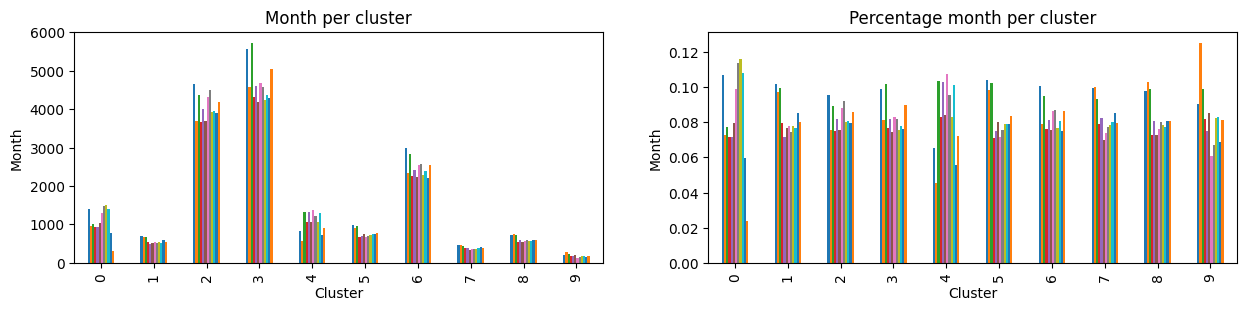

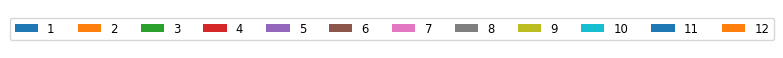

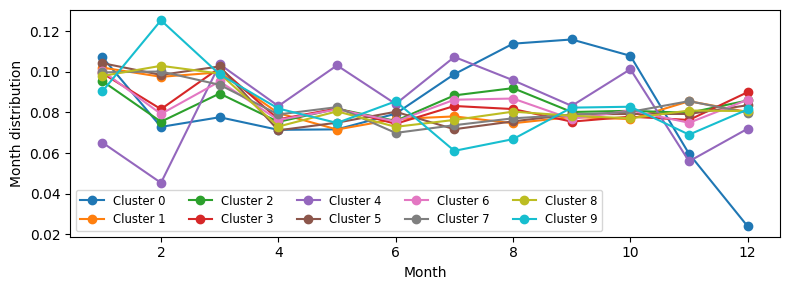

In [375]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(8, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [376]:
year_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               1   11663     514     346     405     148
1               7    1122    1710    1705    1853     434
2               4    6468    9814   14933   14541    3051
3               0    2349   13108   17655   19155    3910
4               0    1690    2287    3744    3916    1127
5               3    1953    2305    2268    2244     554
6               3    3466    6135    8702    9313    2011
7               2     889    1075    1173    1305     291
8               4    1569    1850    1708    1777     458
9              17     623     624     457     423     115

In [377]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000076  0.891871  0.039306  0.026459  0.030970  0.011318
1  0.001025  0.164251  0.250329  0.249597  0.271263  0.063534
2  0.000082  0.132511  0.201061  0.305935  0.297904  0.062506
3  0.000000  0.041814  0.233334  0.314275  0.340976  0.069601
4  0.000000  0.132404  0.179176  0.293325  0.306800  0.088295
5  0.000322  0.209392  0.247132  0.243165  0.240592  0.059397
6  0.000101  0.116976  0.207054  0.293689  0.314310  0.067870
7  0.000422  0.187751  0.227033  0.247730  0.275607  0.061457
8  0.000543  0.213006  0.251154  0.231876  0.241244  0.062178
9  0.007525  0.275786  0.276228  0.202302  0.187251  0.050907

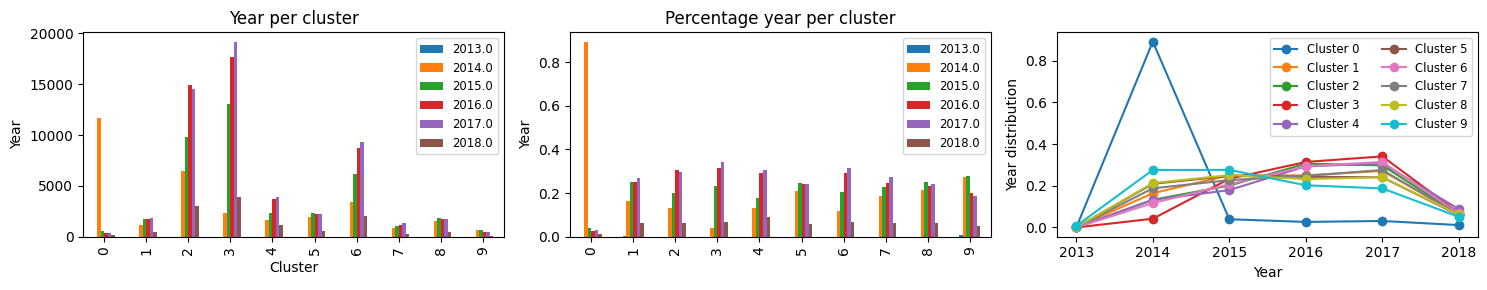

In [382]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small', ncols=2)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [383]:
state_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          220       8      126       240         400       265          262   
1          143       1      161        68         606       122           88   
2         1499       0      680         2        2489       193          206   
3         1337     118      139      1375        2481      1344         1374   
4            0       0        0         0         552         0            0   
5          204       0      272       101         877       183          133   
6          685      30      184       492        1606       487          559   
7          106       0       70        65         355        79           59   
8          131       0      175        64         621       151           79   
9           12       0      103         5         303        41           15   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           215      760      790  ...            20        344    858    74   
1             5      460      198  ...            21        176    547    75   
2            42     1944     2007  ...             0       2044   2326     0   
3           849     4077     2257  ...           293       1635   2493   327   
4             0      601       12  ...             0        430      0     0   
5             7      632      315  ...            31        219    912   110   
6           299     1817     1202  ...            91       1012   1188   109   
7            18      305      179  ...            16        132    323    37   
8             0      530      236  ...            17        144    682    92   
9             0      103       60  ...             1         12    201    28   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           99       172         210             92        251       13  
1           21       225         195             60        131       18  
2           23      1838         330             25       1606        0  
3          107      1020         949            662        719      293  
4            0       194           0              0        495        0  
5           24       281         284             90        166       26  
6           77       685         447            277        545       71  
7            9       118         105             51         77       10  
8           24       248         251             60        138       19  
9            1        69          52              8         65        1  

[10 rows x 50 columns]

In [384]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.016823  0.000612  0.009635  0.018353    0.030588  0.020265     0.020035   
1  0.020934  0.000146  0.023569  0.009955    0.088713  0.017860     0.012882   
2  0.030710  0.000000  0.013931  0.000041    0.050993  0.003954     0.004220   
3  0.023800  0.002101  0.002474  0.024476    0.044164  0.023924     0.024458   
4  0.000000  0.000000  0.000000  0.000000    0.043247  0.000000     0.000000   
5  0.021872  0.000000  0.029163  0.010829    0.094028  0.019620     0.014260   
6  0.023118  0.001012  0.006210  0.016605    0.054202  0.016436     0.018866   
7  0.022386  0.000000  0.014784  0.013728    0.074974  0.016684     0.012460   
8  0.017784  0.000000  0.023758  0.008689    0.084306  0.020500     0.010725   
9  0.005312  0.000000  0.045595  0.002213    0.134130  0.018150     0.006640   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.016441  0.058117  0.060411  ...      0.001529   0.026306  0.065611   
1  0.000732  0.067340  0.028986  ...      0.003074   0.025765  0.080076   
2  0.000860  0.039827  0.041118  ...      0.000000   0.041876  0.047653   
3  0.015113  0.072574  0.040177  ...      0.005216   0.029104  0.044378   
4  0.000000  0.047086  0.000940  ...      0.000000   0.033688  0.000000   
5  0.000751  0.067760  0.033773  ...      0.003324   0.023480  0.097781   
6  0.010091  0.061323  0.040567  ...      0.003071   0.034155  0.040094   
7  0.003801  0.064414  0.037804  ...      0.003379   0.027878  0.068215   
8  0.000000  0.071952  0.032039  ...      0.002308   0.019549  0.092588   
9  0.000000  0.045595  0.026560  ...      0.000443   0.005312  0.088977   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.005659  0.007571  0.013153    0.016059       0.007035   0.019194   
1  0.010979  0.003074  0.032938    0.028546       0.008783   0.019177   
2  0.000000  0.000471  0.037655    0.006761       0.000512   0.032902   
3  0.005821  0.001905  0.018157    0.016893       0.011784   0.012799   
4  0.000000  0.000000  0.015199    0.000000       0.000000   0.038781   
5  0.011794  0.002573  0.030128    0.030449       0.009649   0.017798   
6  0.003679  0.002599  0.023118    0.015086       0.009349   0.018394   
7  0.007814  0.001901  0.024921    0.022175       0.010771   0.016262   
8  0.012490  0.003258  0.033668    0.034075       0.008146   0.018735   
9  0.012395  0.000443  0.030544    0.023019       0.003541   0.028774   

    WYOMING  
0  0.000994  
1  0.002635  
2  0.000000  
3  0.005216  
4  0.000000  
5  0.002788  
6  0.002396  
7  0.002112  
8  0.002579  
9  0.000443  

[10 rows x 50 columns]

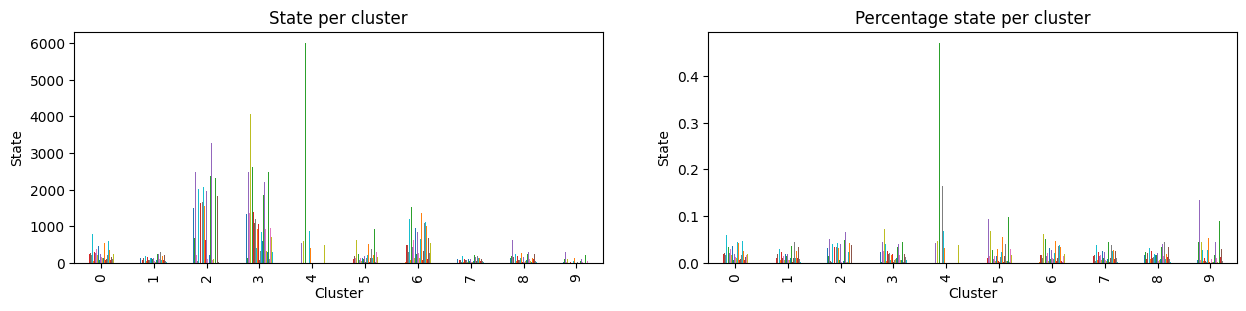

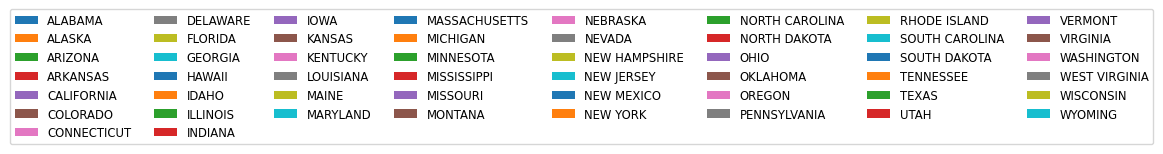

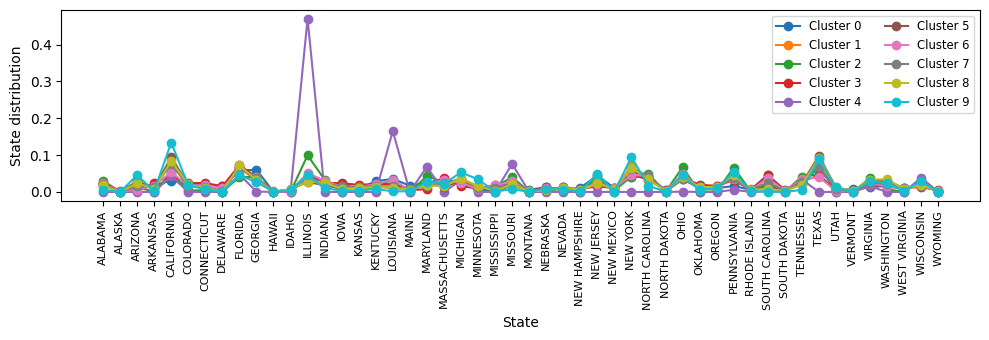

In [386]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [387]:
ic_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   1946                  181   
1                                    658                   21   
2                                   1017                   34   
3                                   1101                   41   
4                                    244                    5   
5                                     16                    3   
6                                    730                   42   
7                                     72                    7   
8                                     34                    0   
9                                     53                    5   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  6   
1                                                 0                  1   
2                                                 2                  1   
3                                                 0                  5   
4                                                 0                  0   
5                                                 0                  1   
6                                                 2                  5   
7                                                 0                  1   
8                                                 0                  1   
9                                                 0                  0   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   48                            16   
1                                   36                             0   
2                                   56                             2   
3                                   30                             5   
4                                   51                             3   
5                                    0                             1   
6                                   28                             1   
7                                    6                             0   
8                                    1                             0   
9                                    2                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      9                 85        26   
1                                      6                 13         1   
2                                      9                 14        11   
3                                      4                 21         9   
4                                      0                  8         4   
5                                      0                  1         1   
6                                      6                 40         6   
7                                      1                  4         2   
8                                      0                  4         1   
9                                      1                  2         1   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       465  ...                  96   
1                                        52  ...                  17   
2                                        89  ...                  22   
3                                       102  ...                  25   
4                                        20  ...                   4   
5                                         4  ...                  22   
6           

In [388]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.148811             0.013841                  0.000000   
1       0.096326             0.003074                  0.000000   
2       0.020835             0.000697                  0.000041   
3       0.019599             0.000730                  0.000000   
4       0.019116             0.000392                  0.000000   
5       0.001715             0.000322                  0.000000   
6       0.024637             0.001417                  0.000067   
7       0.015206             0.001478                  0.000000   
8       0.004616             0.000000                  0.000000   
9       0.023462             0.002213                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000459     0.003671                      0.001224   
1           0.000146     0.005270                      0.000000   
2           0.000020     0.001147                      0.000041   
3           0.000089     0.000534                      0.000089   
4           0.000000     0.003996                      0.000235   
5           0.000107     0.000000                      0.000107   
6           0.000169     0.000945                      0.000034   
7           0.000211     0.001267                      0.000000   
8           0.000136     0.000136                      0.000000   
9           0.000000     0.000885                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000688           0.006500  0.001988          0.035559  ...   
1       0.000878           0.001903  0.000146          0.007612  ...   
2       0.000184           0.000287  0.000225          0.001823  ...   
3       0.000071           0.000374  0.000160          0.001816  ...   
4       0.000000           0.000627  0.000313          0.001567  ...   
5       0.000000           0.000107  0.000107          0.000429  ...   
6       0.000202           0.001350  0.000202          0.002734  ...   
7       0.000211           0.000845  0.000422          0.002746  ...   
8       0.000000           0.000543  0.000136          0.000815  ...   
9       0.000443           0.000885  0.000443          0.005755  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.007341      0.000000        0.000076    0.019576  0.000382   
1            0.002489      0.000000        0.000146    0.006295  0.000000   
2            0.000451      0.000020        0.000020    0.001229  0.000102   
3            0.000445      0.000036        0.000000    0.002688  0.000178   
4            0.000313      0.000078        0.000000    0.000548  0.000000   
5            0.002359      0.000000        0.000000    0.001823  0.000536   
6            0.001080      0.000000        0.000000    0.002261  0.000169   
7            0.000422      0.000000        0.000000    0.004435  0.000000   
8            0.001358      0.000000        0.000000    0.003665  0.000000   
9            0.003984      0.000000        0.000000    0.004869  0.000000   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.001224    0.081594         0.000153        0.049400   
1         0.000439    0.008491         0.000000        0.010979   
2         0.000143    0.006269         0.000020        0.002991   
3         0.000231    0.002029         0.000000        0.001727   
4         0.000313    0.002037         0.000000        0.003055   
5         0.000214    0.006862         0.000000        0.000536   
6         0.000506    0.006952         0.000067        0.003037   
7         0.000634    0.010771         0.000000        0.003801   
8         0.000815    0.011540         0.000000        0.001222   
9         0.000885    0.009296         0.000000        0.004427   

   UNLAWFUL_PURCHASE_SALE  
0                0.000076  
1                0.000000  
2                0.000000  
3                0.000000  
4       

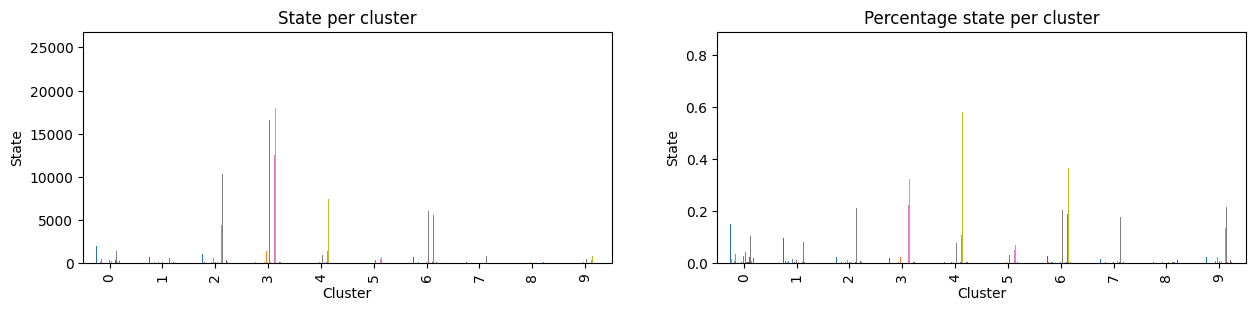

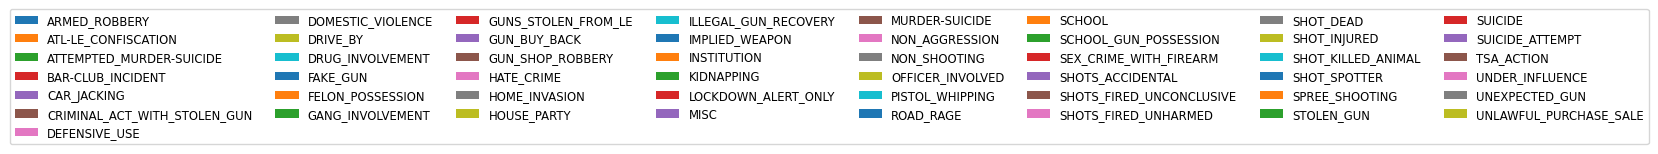

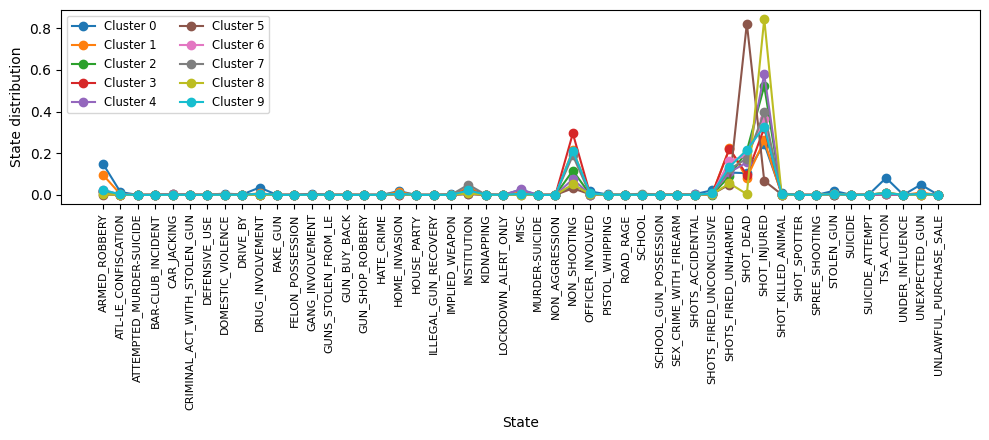

In [390]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators reduced clustering

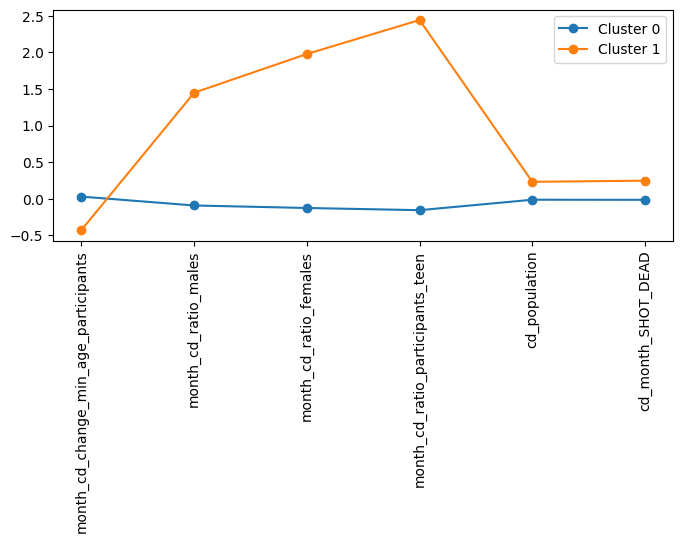

In [391]:
centers = best_model_ind_r.cluster_centers_
cols = reduced_ind.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

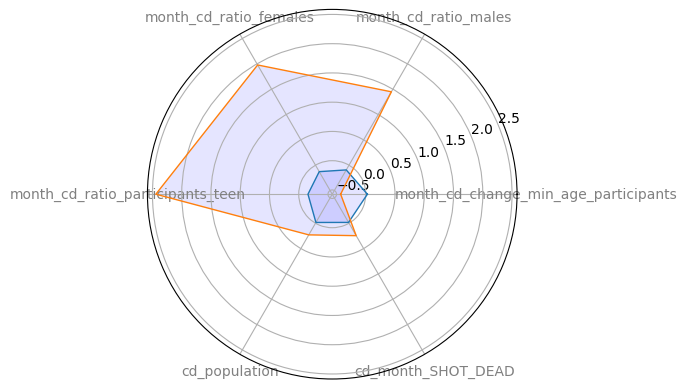

In [392]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [394]:
party_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        104956       74461
1          4558        7002

In [395]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.584984    0.415016
1  0.394291    0.605709

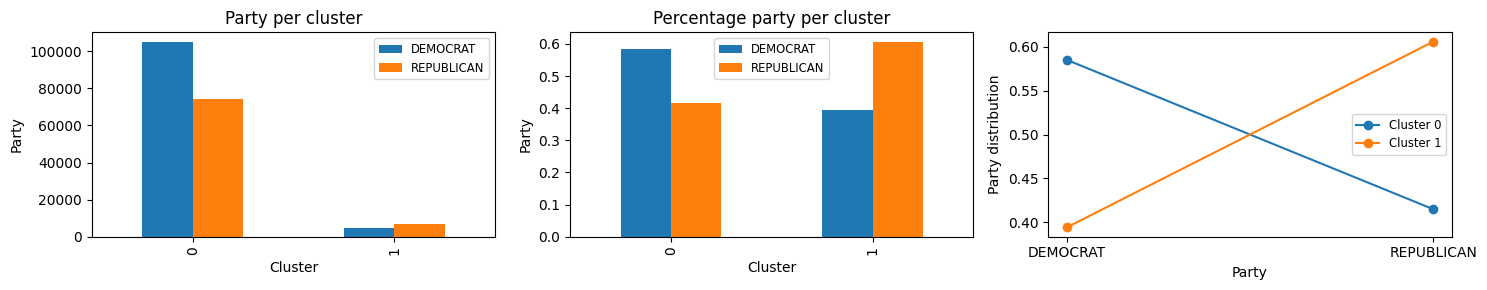

In [396]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [397]:
day_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6543  5634  5774  5852  5961  5830  5803  5836  5683  5669  ...   
1          417   396   359   364   390   399   368   353   384   343  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5680  5852  5720  6079  5959  6000  5924  5585  5469  3594  
1          401   384   336   396   394   387   399   358   337   222  

[2 rows x 31 columns]

In [398]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036468  0.031402  0.032182  0.032617  0.033224  0.032494  0.032344   
1  0.036073  0.034256  0.031055  0.031488  0.033737  0.034516  0.031834   

         8         9         10  ...        22        23        24        25  \
0  0.032528  0.031675  0.031597  ...  0.031658  0.032617  0.031881  0.033882   
1  0.030536  0.033218  0.029671  ...  0.034689  0.033218  0.029066  0.034256   

         26        27        28        29        30        31  
0  0.033213  0.033442  0.033018  0.031129  0.030482  0.020032  
1  0.034083  0.033478  0.034516  0.030969  0.029152  0.019204  

[2 rows x 31 columns]

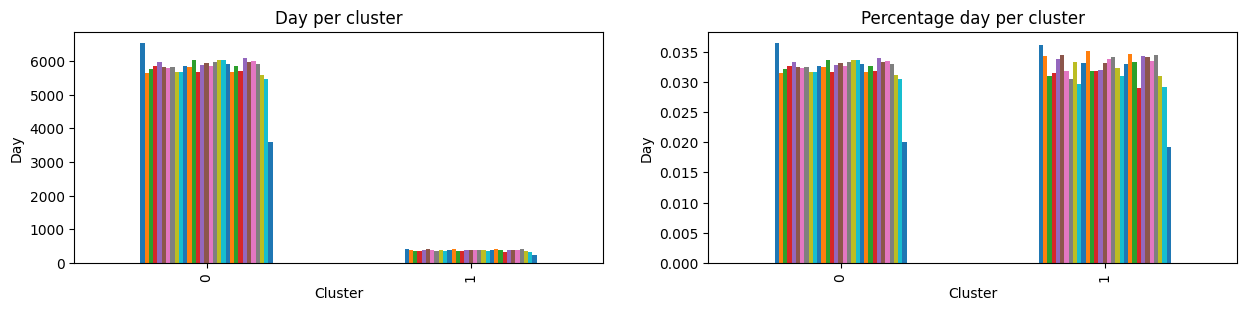

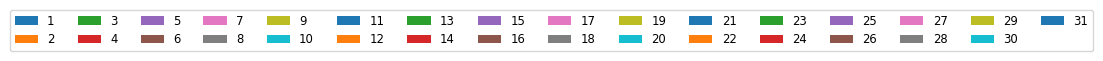

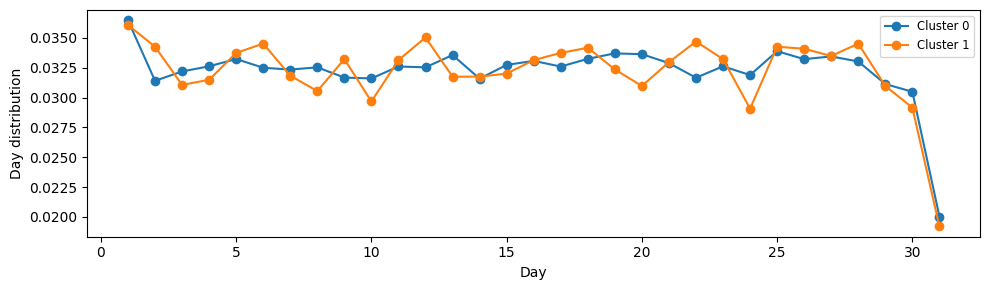

In [399]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [400]:
month_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           17377  14024  17156  13643  14657  13680  15607  15808  14548   
1            1133   1219   1119    897    943    884    844    871    860   

date_month     10     11     12  
row_0                            
0           14888  13423  14606  
1             930    950    910

In [401]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096853  0.078164  0.095621  0.076041  0.081692  0.076247  0.086987   
1  0.098010  0.105450  0.096799  0.077595  0.081574  0.076471  0.073010   

         8         9        10        11        12  
0  0.088108  0.081085  0.08298  0.074815  0.081408  
1  0.075346  0.074394  0.08045  0.082180  0.078720

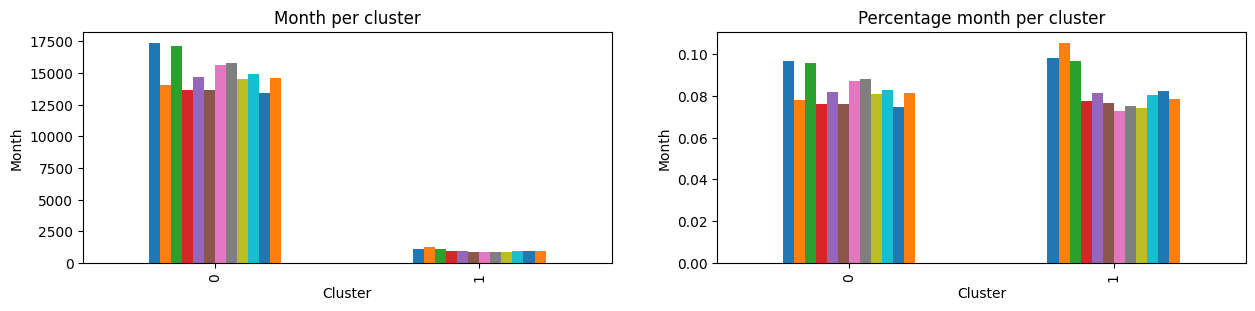

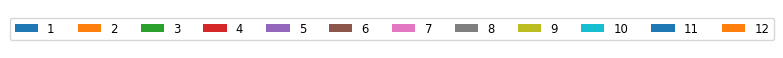

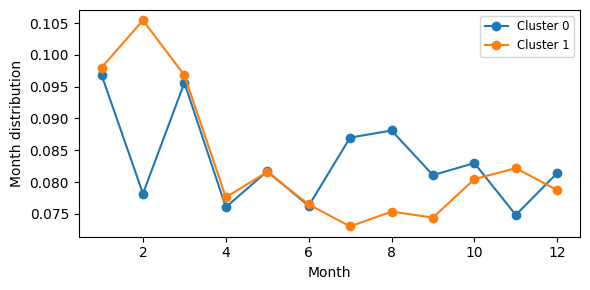

In [402]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [403]:
year_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              23   29147   36667   49994   52177   11409
1              18    2645    2755    2697    2755     690

In [404]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000128  0.162454  0.204367  0.278647  0.290814  0.063589
1  0.001557  0.228806  0.238322  0.233304  0.238322  0.059689

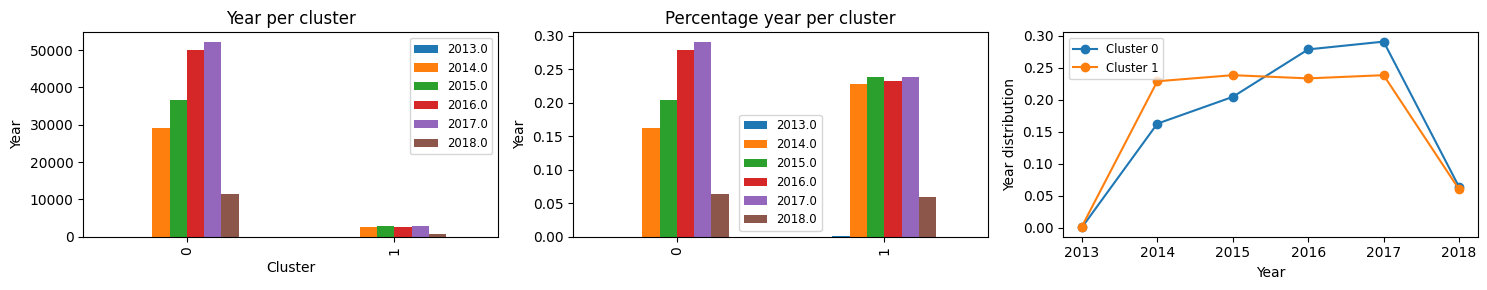

In [405]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [406]:
state_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4135     157     1612      2292        9267      2651         2647   
1          202       0      298       120        1023       214          128   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1412    10509     6870  ...           461       5896   8563   741   
1            23      720      386  ...            29        252    967   111   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          359      4535        2534           1224       3955      423  
1           26       315         289            101        238       28  

[2 rows x 50 columns]

In [407]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.023047  0.000875  0.008985  0.012775    0.051651  0.014776     0.014753   
1  0.017474  0.000000  0.025779  0.010381    0.088495  0.018512     0.011073   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0   0.00787  0.058573  0.038291  ...      0.002569   0.032862  0.047727   
1   0.00199  0.062284  0.033391  ...      0.002509   0.021799  0.083651   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004130  0.002001  0.025276    0.014124       0.006822   0.022044   
1  0.009602  0.002249  0.027249    0.025000       0.008737   0.020588   

    WYOMING  
0  0.002358  
1  0.002422  

[2 rows x 50 columns]

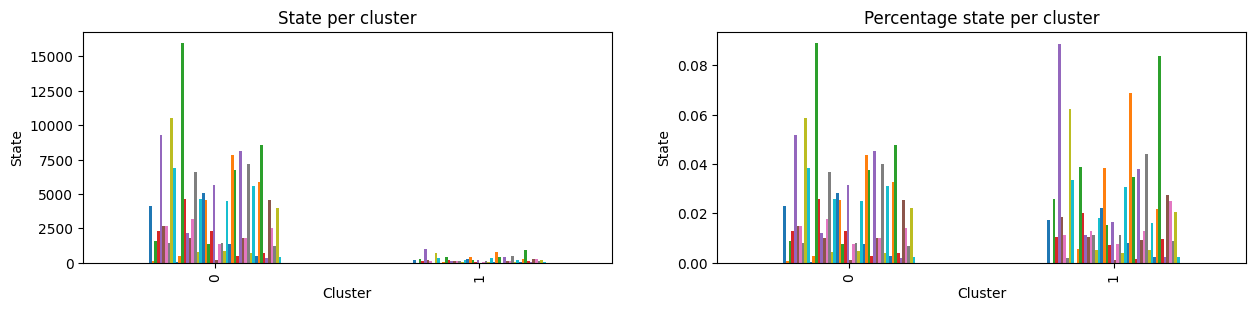

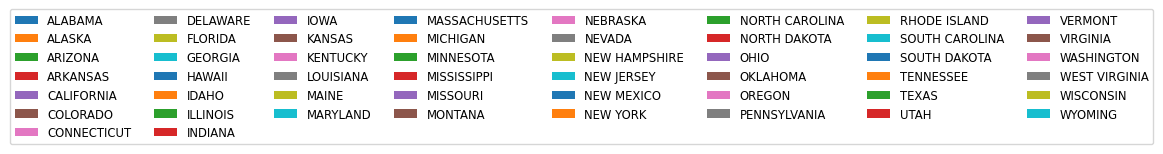

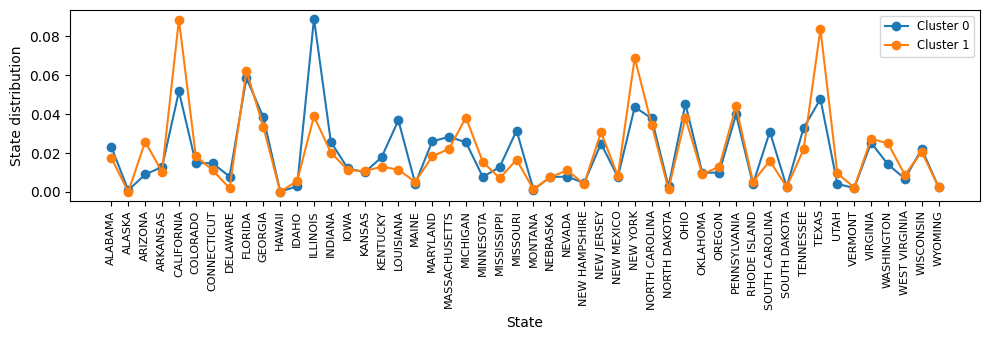

In [408]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [409]:
ic_xt_pct = pd.crosstab(best_model_ind_r.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5613                  321   
1                                    258                   18   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 20   
1                                                 0                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  229                            28   
1                                   29                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     34                161        59   
1                                      2                 31         3   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       793  ...                 214   
1                                        52  ...                  25   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               2         607       30   
1                                     0               1          53        0   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       61        1858                5   
1                                       10         140                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1081                       1  
1                                      54                       0  

[2 rows x 49 columns]

In [410]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.031285             0.001789                  0.000022   
1       0.022318             0.001557                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000111     0.001276                      0.000156   
1           0.000087     0.002509                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000190           0.000897  0.000329          0.004420  ...   
1       0.000173           0.002682  0.000260          0.004498  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001193      0.000022        0.000011    0.003383  0.000167   
1            0.002163      0.000000        0.000087    0.004585  0.000000   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000340    0.010356         0.000028        0.006025   
1         0.000865    0.012111         0.000000        0.004671   

   UNLAWFUL_PURCHASE_SALE  
0                0.000006  
1                0.000000  

[2 rows x 49 columns]

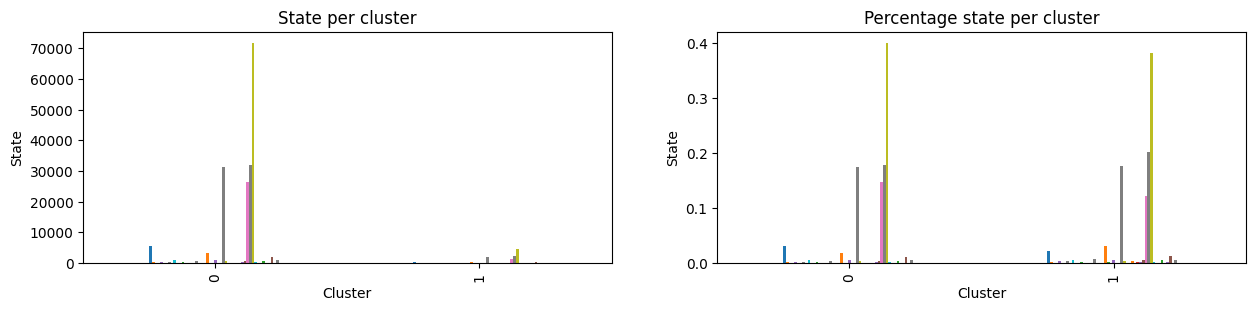

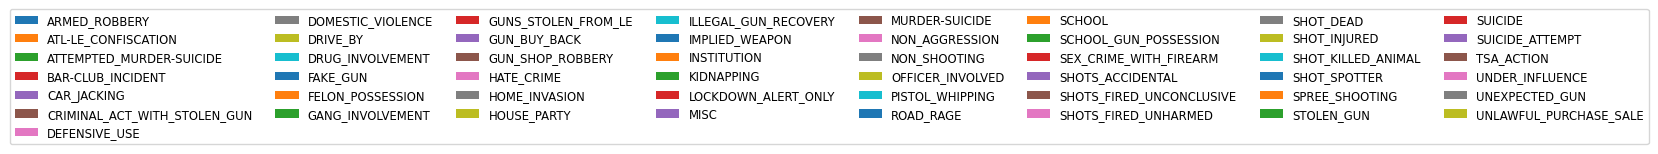

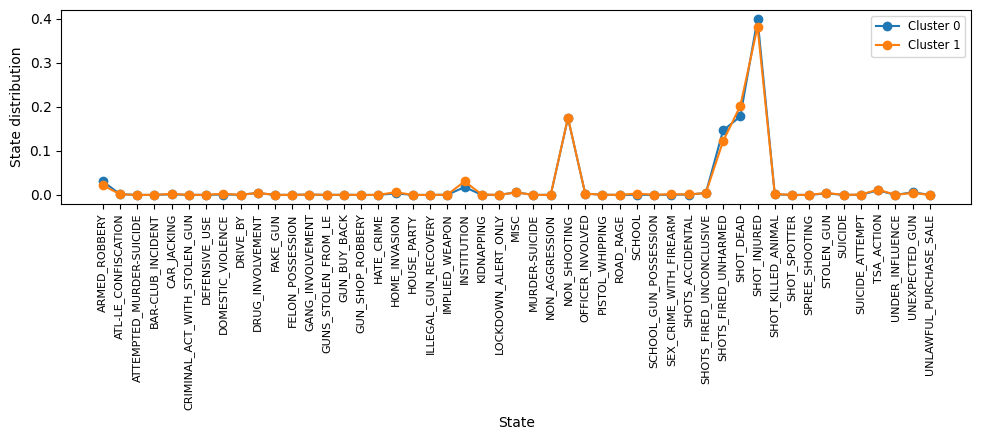

In [411]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()